In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from scipy.stats import boxcox
from scipy.stats.contingency import association

from sklearn.preprocessing import LabelEncoder

from helper_function import (
    get_var, 
    cat_value_count, 
    outlier_thresholds, 
    loc_potential_outliers, 
    any_potential_outlier, 
    delete_potential_outlier, 
    delete_potential_outlier_list, 
    plot_continuous, 
    plot_categorical, 
    plot_features_label, 
    plot_label_features 
)

pd.set_option('display.max_columns', None)

In [2]:
color_palette = ["#191970", "#708090", "#4682B4", "#87CEFA", "#C5FFFD", "#FAF9F9"]
color_palette_secondary = ["#1E352F","#134611","#3E8914","#3DA35D","#96E072","#E8FCCF"]
fp = matplotlib.font_manager.FontProperties(
    fname='/Fonts/roboto/Roboto-Condensed.ttf')
sns.set_palette(color_palette)
sns.set_style("darkgrid")

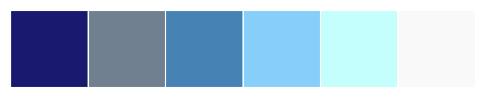

In [3]:
sns.set_palette(color_palette)
sns.palplot(sns.color_palette())

In [4]:
sns.set_palette(color_palette)

# Dataset Info

   #### Source:
   https://archive.ics.uci.edu/dataset/222/bank+marketing

   #### Train data:
| No. | Features | Description |
| :-------- | :-------- | :-------- |
| 1. | age | (numeric) |
| 2. | job | type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services")  |
| 3. | marital | marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed) |
| 4. | education | (categorical: "unknown","secondary","primary","tertiary") |
| 5. | default | has credit in default? (binary: "yes","no") |
| 6. | balance | average yearly balance, in euros (numeric)  |
| 7. | housing | has housing loan? (binary: "yes","no") |
| 8. | loan | has personal loan? (binary: "yes","no") |
| 9. | contact | contact communication type (categorical: "unknown","telephone","cellular") |
| 10. | day | last contact day of the month (numeric) |
| 11. | month | last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec") |
| 12. | duration | last contact duration, in seconds (numeric) |
| 13. | campaign | number of contacts performed during this campaign and for this client (numeric, includes last contact) |
| 14. | pdays | number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted) |
| 15. | previous | number of contacts performed before this campaign and for this client (numeric) |
| 16. | poutcome | outcome of the previous marketing campaign (categorical: "unknown","other","failure","success") |

  #### Target variable:
| No. | Target | Description |
| :-------- | :-------- | :-------- |
| 17. | y | has the client subscribed a term deposit? (binary: "yes","no") |


# Exploratory Data Analysis

In [5]:
df = (pd
      .read_csv("bank-full.csv", sep=';')
      .rename(columns={'y': 'deposit'})
      .pipe(lambda df_: df_.assign(deposit=np.where(df_.deposit == "no", 0, 1)))
      )
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [6]:
print(f'Train data \nNumber of rows : {df.shape[0]}\nNumber of columns: {df.shape[1]}')

Train data 
Number of rows : 45211
Number of columns: 17


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  deposit    45211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


In [8]:
(df
 .deposit
 .value_counts(normalize=True)
 .to_frame()
 .reset_index()
)

,index,deposit
0,0,0.883015
1,1,0.116985


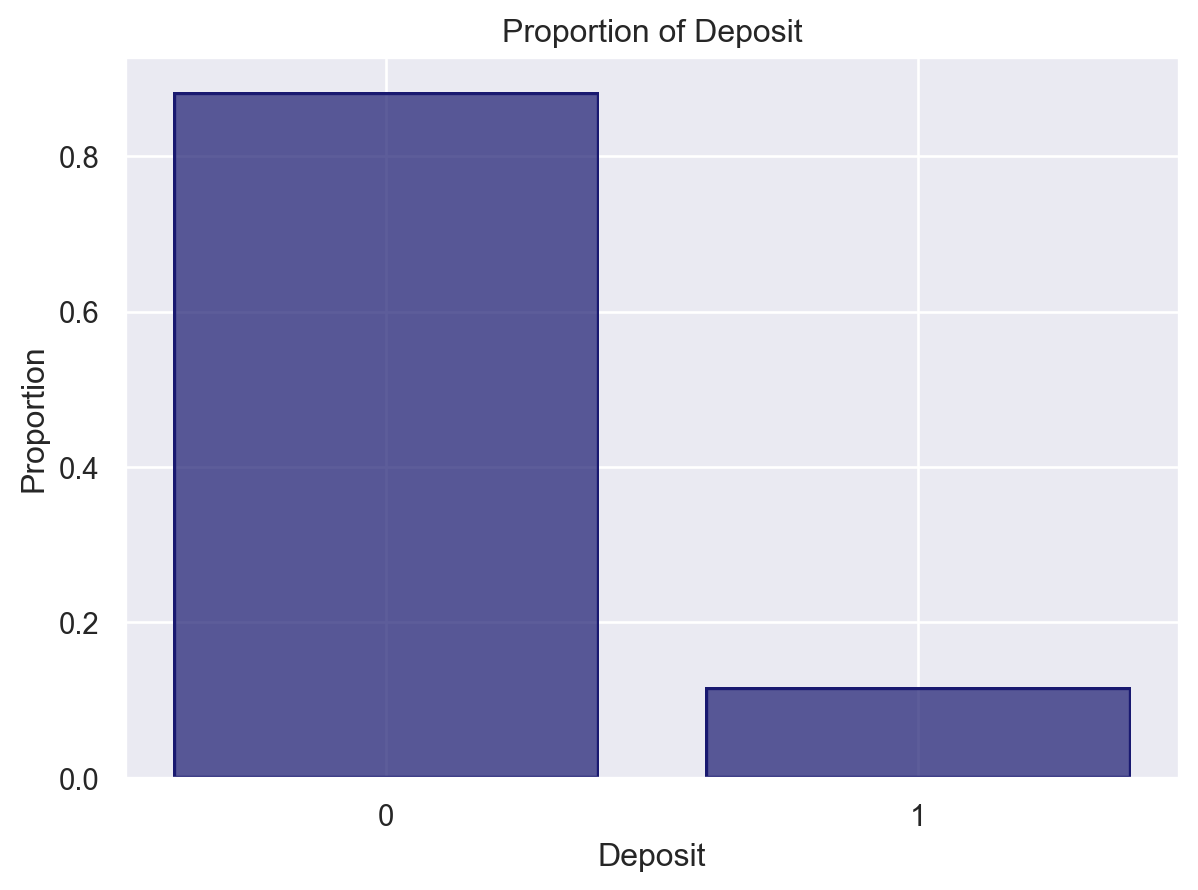

In [9]:
(so
 .Plot((df
        .deposit
        .value_counts(normalize=True)
        .to_frame()
        .reset_index()
       ),
       x='index',
       y='deposit')
 .add(so.Bar(),)
 .scale(x=so.Continuous().tick(between=(0, 1), count=2))
 .label(x='Deposit',
        y='Proportion',
        color=str.capitalize,
        title=f'Proportion of Deposit')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0]])})
)

### Univariate Analysis (Continuous)

In [10]:
df.describe(percentiles = [.25,.50,.75,.95,.99])

,age,balance,day,duration,campaign,pdays,previous,deposit
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
95%,59.000000,5768.000000,29.000000,751.000000,8.000000,317.000000,3.000000,1.000000
99%,71.000000,13164.900000,31.000000,1269.000000,16.000000,370.000000,8.900000,1.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [11]:
print(f'Based on 1.5xIQR outlier detection formula:\n')
for col in ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']:
    print(f'Column {col}: Detected total of {any_potential_outlier(df, col)} potential outliers')

Based on 1.5xIQR outlier detection formula:

Column age: Detected total of 0 potential outliers
Column balance: Detected total of 360 potential outliers
Column day: Detected total of 0 potential outliers
Column duration: Detected total of 97 potential outliers
Column campaign: Detected total of 331 potential outliers
Column pdays: Detected total of 11 potential outliers
Column previous: Detected total of 582 potential outliers


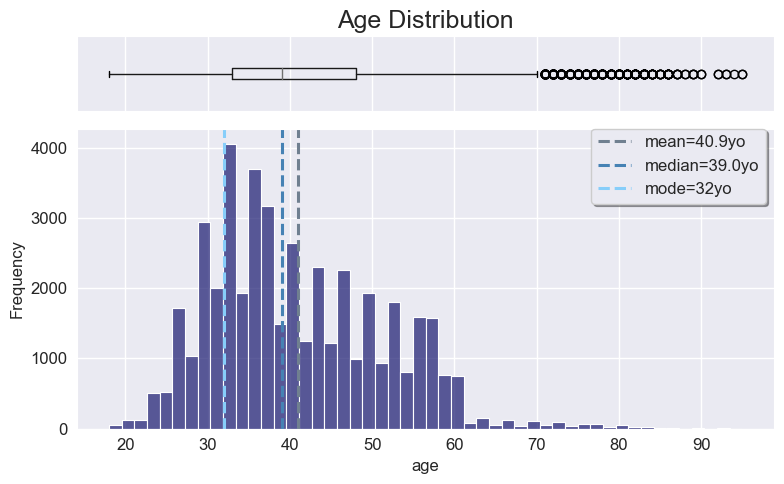

In [12]:
plot_continuous(df, 'age', 'Age Distribution', 'yo')

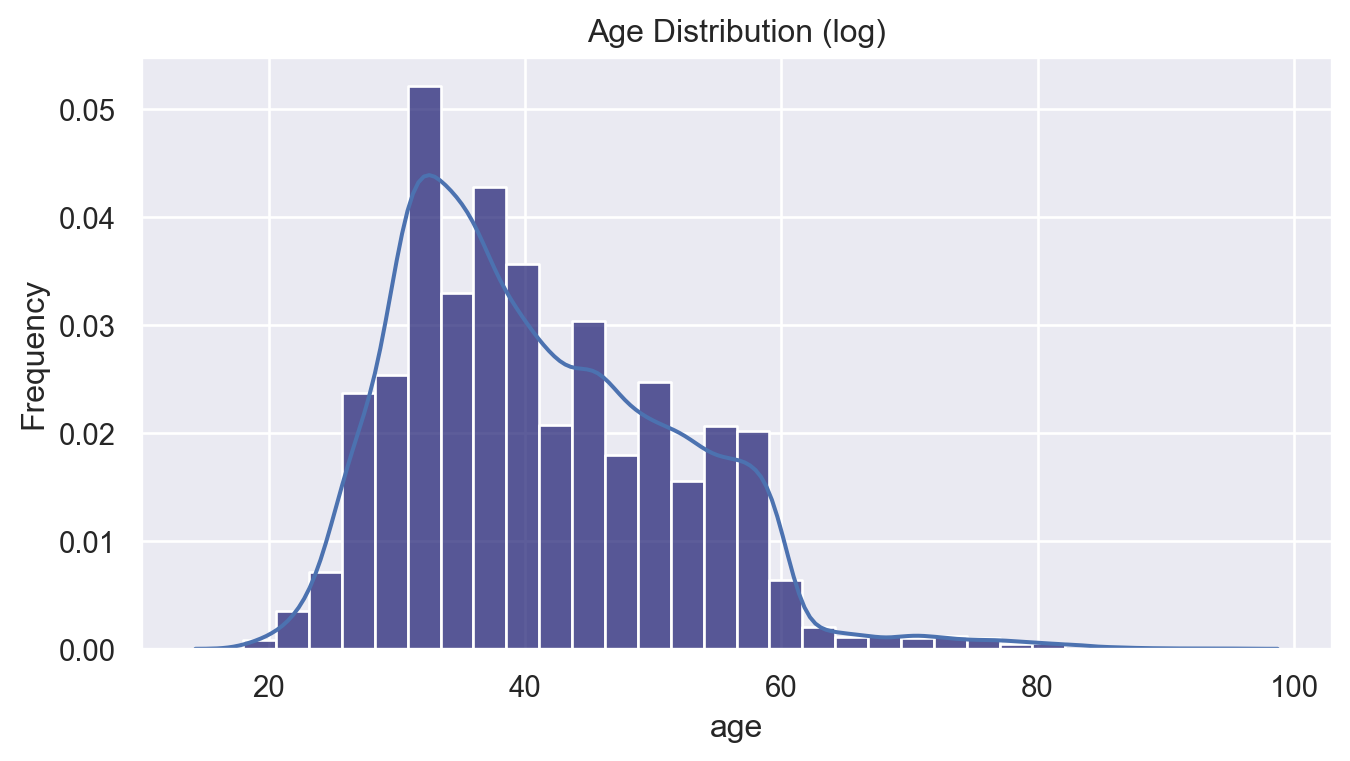

In [13]:
#Trying log-transformation
(so
 .Plot(df
       .age)
 .add(so.Bars(color=color_palette[0]), 
      so.Hist("density", bins=30),)
 .add(so.Line(), so.KDE())
 .label(x='age',
        y='Frequency',
        color=str.capitalize,
        title='Age Distribution (log)',)
 .on(matplotlib.figure.Figure(figsize=(8,4)))
 .plot()
)

In [14]:
loc_potential_outliers(df, "age")

Detected total of 0 potential outliers based on 1.5xIQR


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit


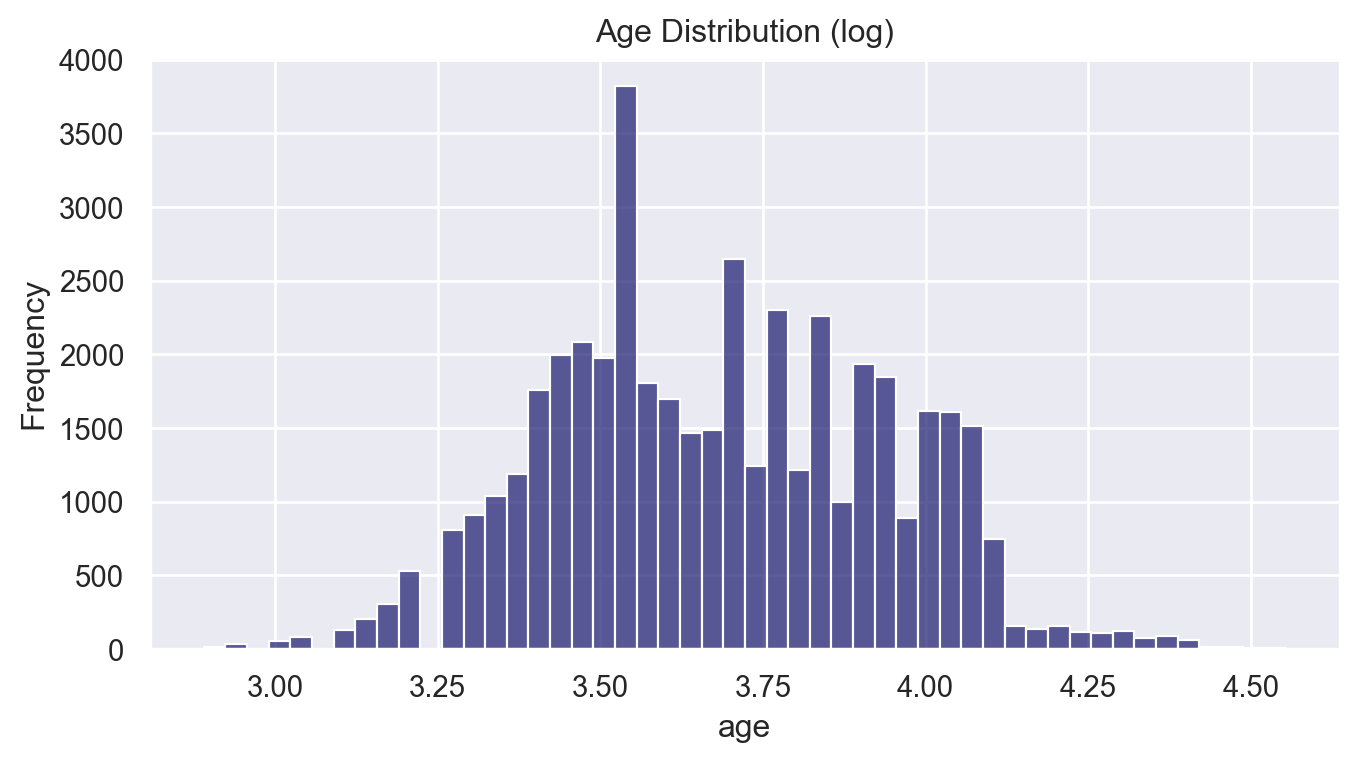

In [15]:
#Trying log-transformation
(so
 .Plot(df
       .age
       .transform(np.log),)
 .add(so.Bars(color=color_palette[0]), so.Hist(bins=50))
 .label(x='age',
        y='Frequency',
        color=str.capitalize,
        title='Age Distribution (log)',)
 .on(matplotlib.figure.Figure(figsize=(8,4)))
 .plot()
)

Box-Cox Transformation applied with lambda = -0.16368117914120728


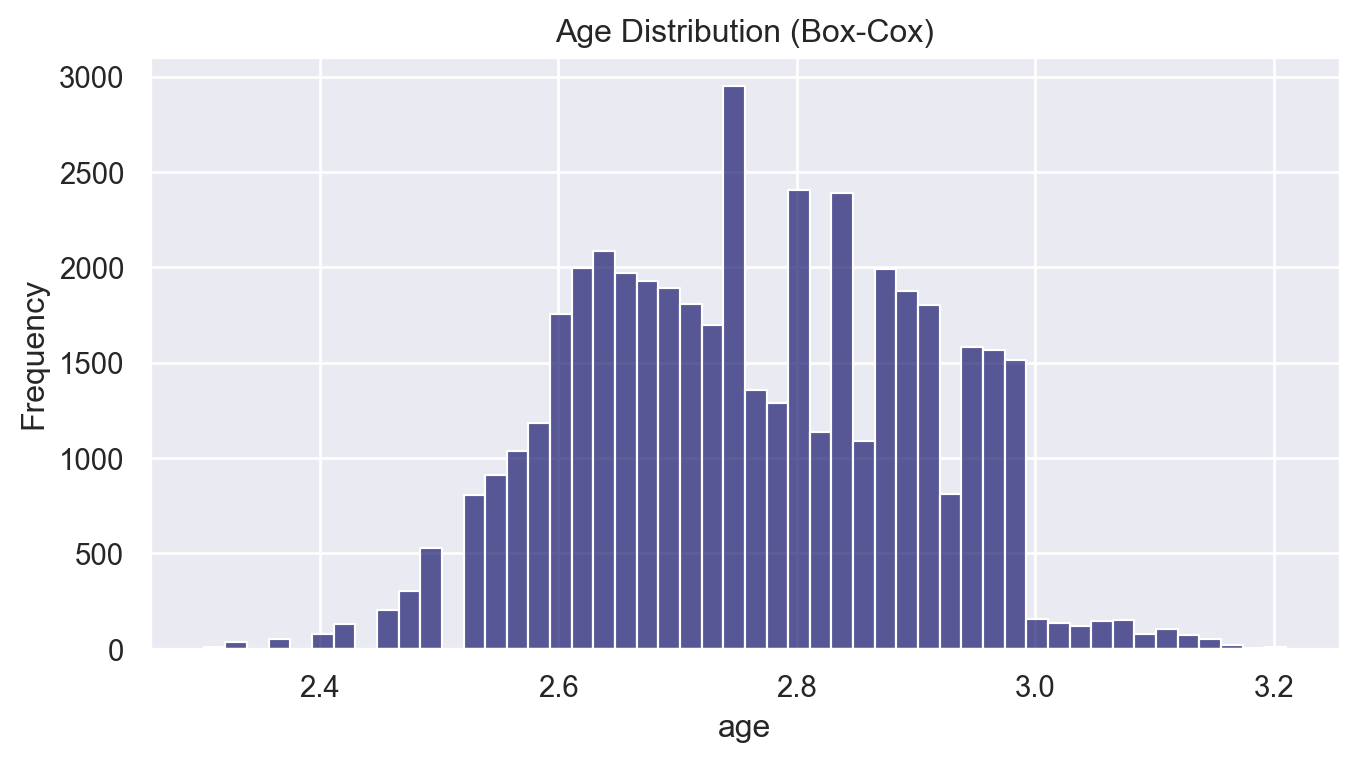

In [16]:
#Trying box-cox-transformation
print(f'Box-Cox Transformation applied with lambda = {boxcox(df.age)[1]}')

(so
 .Plot(pd
       .Series(boxcox(df.age)[0]))
 .add(so.Bars(color=color_palette[0]), so.Hist(bins=50))
 .label(x='age',
        y='Frequency',
        color=str.capitalize,
        title='Age Distribution (Box-Cox)',)
 .on(matplotlib.figure.Figure(figsize=(8,4)))
 .plot()
)   

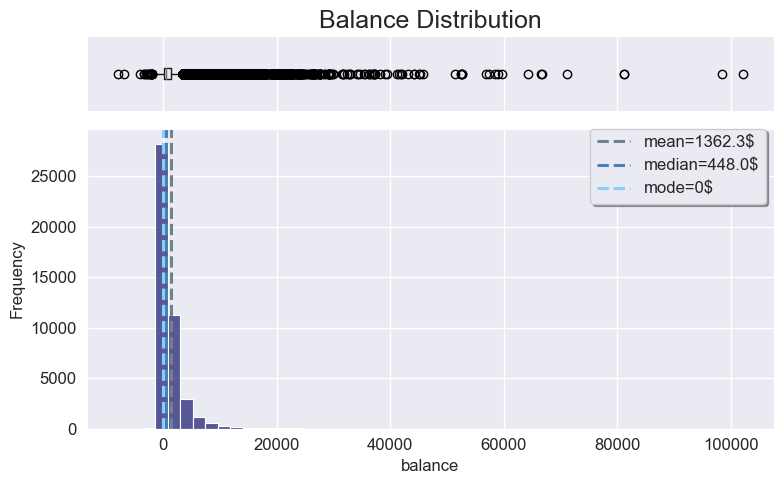

In [17]:
plot_continuous(df, 'balance', 'Balance Distribution', '$')

In [18]:
(df
 .loc[df.balance < 0]
)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
25,44,admin.,married,secondary,no,-372,yes,no,unknown,5,may,172,1,-1,0,unknown,0
28,46,management,single,secondary,no,-246,yes,no,unknown,5,may,255,2,-1,0,unknown,0
36,25,blue-collar,married,secondary,no,-7,yes,no,unknown,5,may,365,1,-1,0,unknown,0
37,53,technician,married,secondary,no,-3,no,no,unknown,5,may,1666,1,-1,0,unknown,0
45,36,admin.,single,primary,no,-171,yes,no,unknown,5,may,242,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44626,31,services,single,secondary,no,-205,no,no,cellular,1,sep,481,1,579,1,failure,1
44629,28,blue-collar,single,secondary,no,-46,yes,no,cellular,1,sep,199,1,92,14,success,1
44836,33,blue-collar,married,primary,no,-195,no,no,unknown,20,sep,9,1,-1,0,unknown,0
44908,48,management,divorced,tertiary,no,-130,yes,no,cellular,29,sep,110,2,61,9,failure,0


In [19]:
loc_potential_outliers(df, "balance")

Detected total of 360 potential outliers based on 1.5xIQR


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
334,45,management,divorced,tertiary,no,24598,yes,no,unknown,5,may,313,3,-1,0,unknown,0
446,39,technician,single,unknown,no,45248,yes,no,unknown,6,may,1623,1,-1,0,unknown,1
920,44,admin.,married,secondary,no,58544,yes,no,unknown,7,may,144,2,-1,0,unknown,0
2065,55,retired,married,secondary,no,18722,yes,no,unknown,12,may,128,2,-1,0,unknown,0
2343,26,technician,single,secondary,no,24299,yes,no,unknown,13,may,704,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44521,42,management,married,tertiary,no,27696,no,no,cellular,11,aug,370,1,91,7,success,1
44861,55,management,divorced,tertiary,no,26306,yes,no,cellular,23,sep,84,1,589,4,failure,0
44874,36,unemployed,married,secondary,no,17458,no,no,cellular,23,sep,390,2,-1,0,unknown,0
45019,57,admin.,married,secondary,no,16873,no,no,cellular,14,oct,219,3,372,1,failure,0


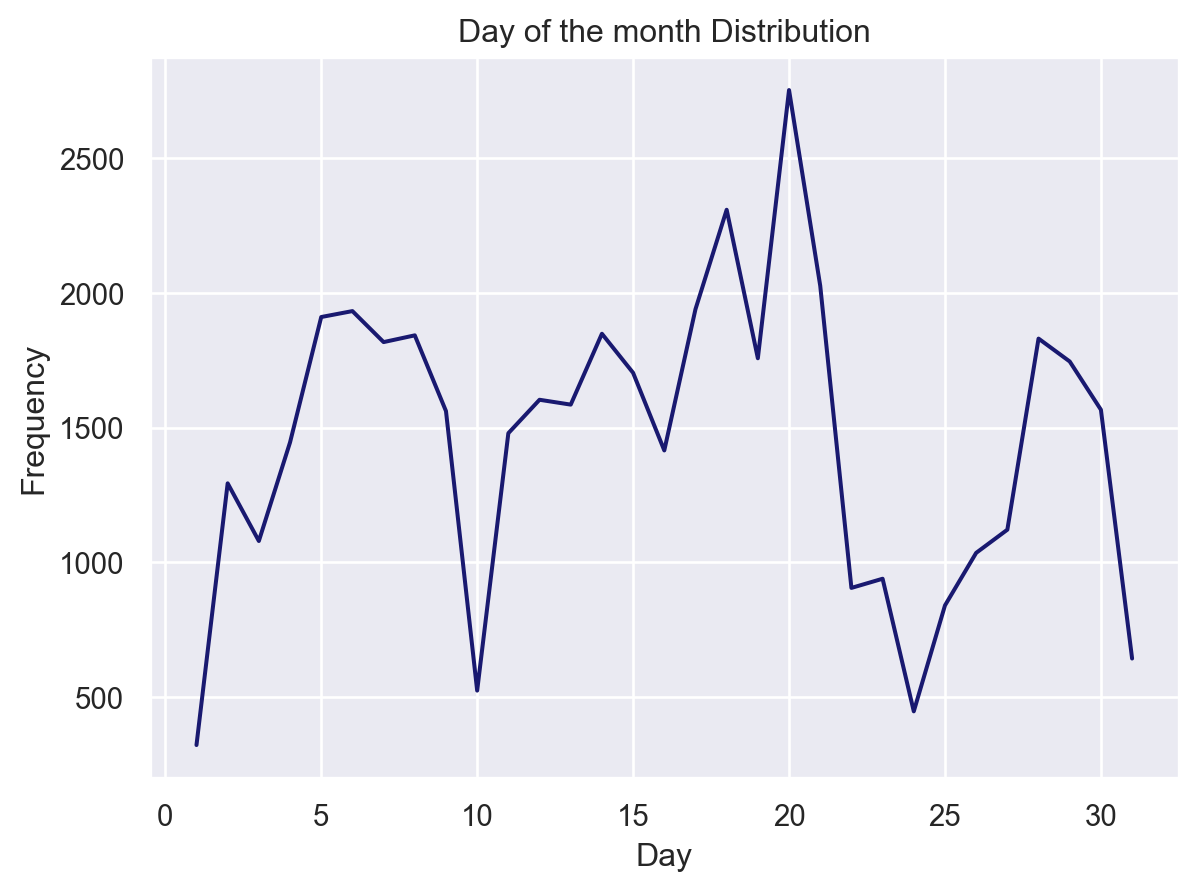

In [20]:
(so
 .Plot((df
         .day
         .value_counts()
         .sort_index()
         .to_frame()
         .reset_index()
        ),
       x="index",
       y="day")
 .add(so.Line(color=color_palette[0]))
 .label(x="Day",
        y='Frequency',
        color=str.capitalize,
        title=f'Day of the month Distribution')
 .plot()
)

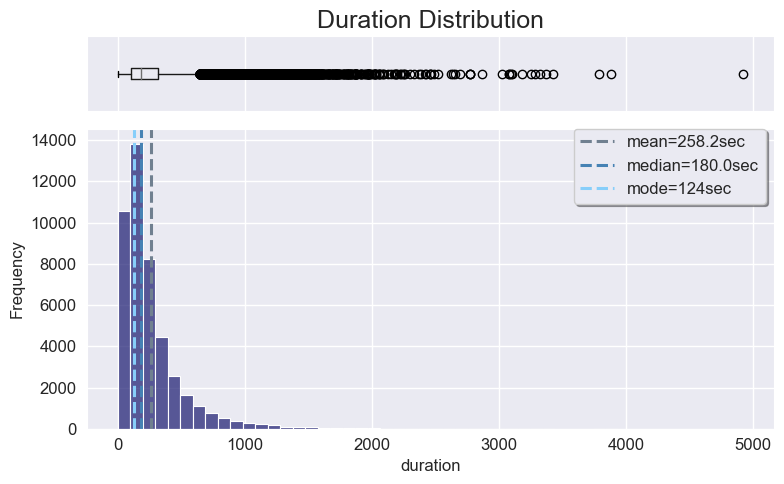

In [21]:
plot_continuous(df, 'duration', 'Duration Distribution', 'sec')

In [22]:
loc_potential_outliers(df, "duration")

Detected total of 97 potential outliers based on 1.5xIQR


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
152,40,management,married,tertiary,no,-4,yes,no,unknown,5,may,2033,1,-1,0,unknown,0
600,38,blue-collar,married,secondary,no,384,yes,no,unknown,6,may,1906,3,-1,0,unknown,0
1034,41,blue-collar,single,secondary,no,277,yes,no,unknown,7,may,2177,4,-1,0,unknown,0
1416,43,management,divorced,tertiary,no,388,yes,no,unknown,8,may,2087,2,-1,0,unknown,1
1731,41,blue-collar,married,primary,no,406,yes,no,unknown,9,may,2462,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42265,63,management,married,tertiary,no,5112,no,no,telephone,13,nov,2184,2,95,3,failure,1
42534,68,retired,married,secondary,no,1443,no,no,telephone,21,dec,2062,2,257,1,success,1
43032,38,services,married,secondary,no,775,no,no,cellular,12,feb,1835,3,182,2,success,1
43901,50,technician,single,tertiary,no,2,no,no,unknown,10,jun,2389,1,-1,0,unknown,0


In [23]:
(df
 .loc[df.duration == 0]
)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
6424,53,management,married,primary,no,351,yes,no,unknown,27,may,0,4,-1,0,unknown,0
22937,35,technician,married,secondary,no,5535,no,no,cellular,26,aug,0,15,-1,0,unknown,0
36425,31,entrepreneur,married,secondary,no,162,yes,yes,cellular,11,may,0,2,-1,0,unknown,0


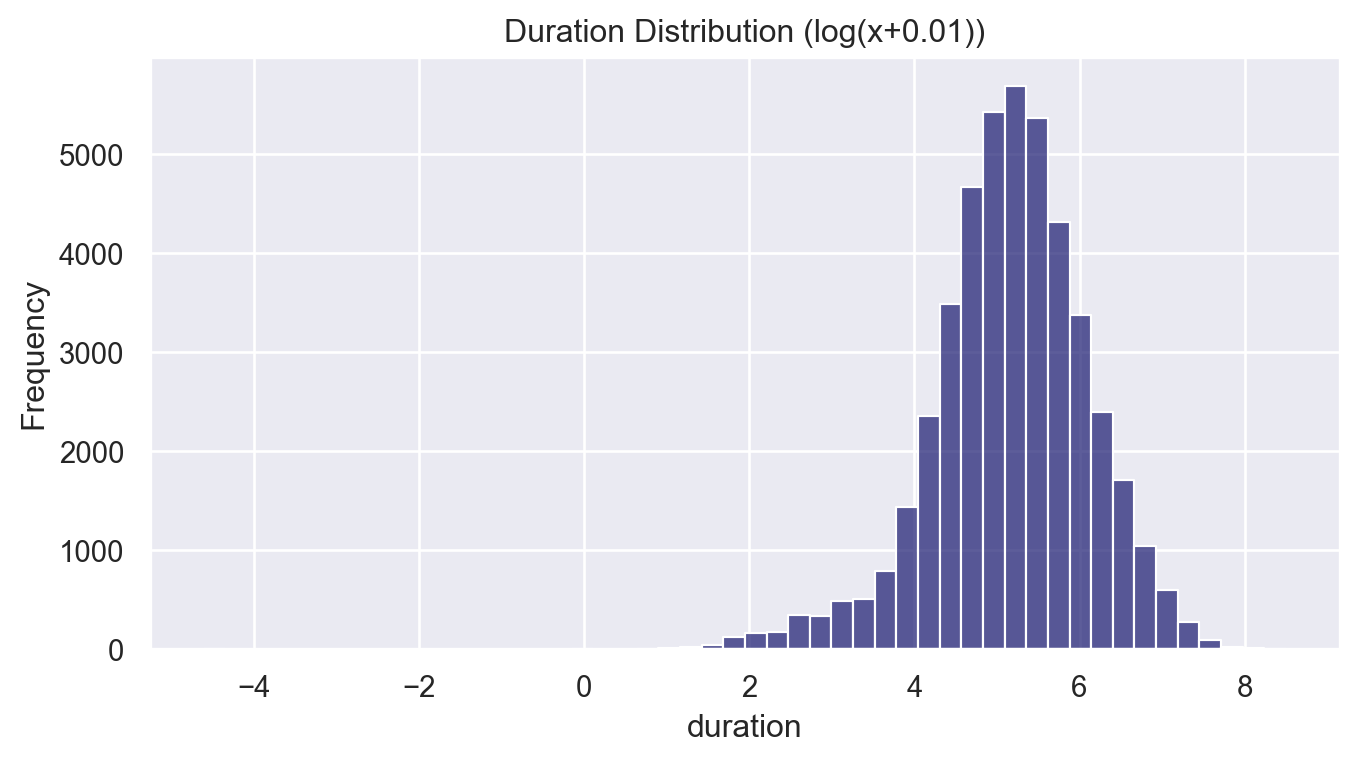

In [24]:
#Trying log-transformation
(so
 .Plot(df
       .duration
       .transform(lambda x: np.log(x+0.01)),)
 .add(so.Bars(color=color_palette[0]), so.Hist(bins=50))
 .label(x='duration',
        y='Frequency',
        color=str.capitalize,
        title='Duration Distribution (log(x+0.01))',)
 .on(matplotlib.figure.Figure(figsize=(8,4)))
 .plot()
)

Box-Cox Transformation applied with lambda = 0.1479489780800578


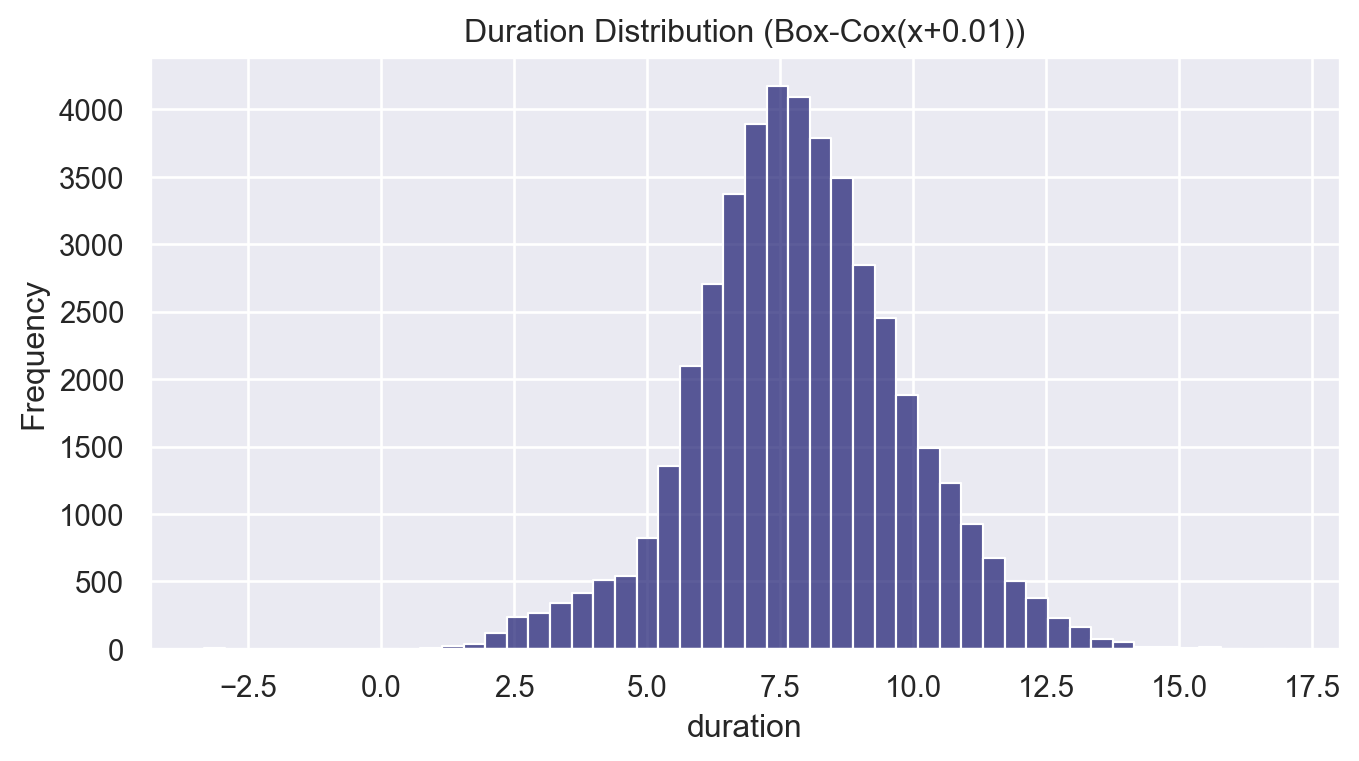

In [25]:
#Trying box-cox-transformation
print(f'Box-Cox Transformation applied with lambda = {boxcox(df.duration.transform(lambda x: x+0.01))[1]}')

(so
 .Plot(pd
       .Series(boxcox(df.duration.transform(lambda x: x+0.01))[0]))
 .add(so.Bars(color=color_palette[0]), so.Hist(bins=50))
 .label(x='duration',
        y='Frequency',
        color=str.capitalize,
        title='Duration Distribution (Box-Cox(x+0.01))',)
 .on(matplotlib.figure.Figure(figsize=(8,4)))
 .plot()
)   

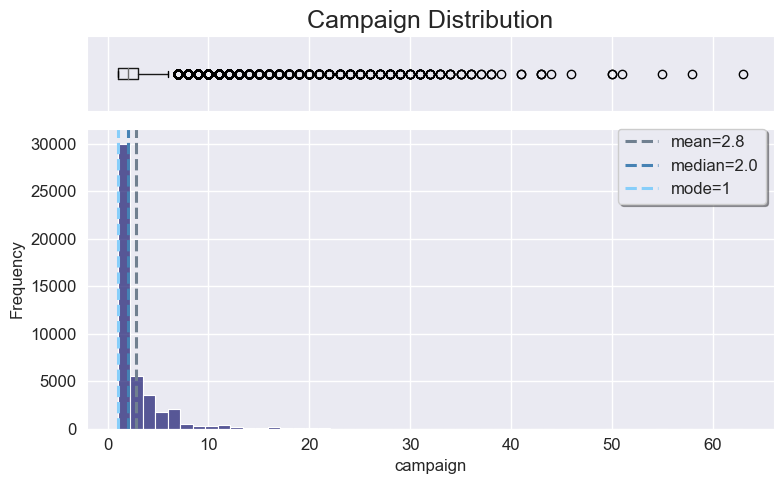

In [26]:
plot_continuous(df, 'campaign', 'Campaign Distribution', '')

In [27]:
loc_potential_outliers(df, "campaign")

Detected total of 331 potential outliers based on 1.5xIQR


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
2706,46,admin.,divorced,tertiary,no,3749,yes,no,unknown,13,may,69,19,-1,0,unknown,0
3079,28,blue-collar,married,primary,no,0,no,no,unknown,14,may,17,24,-1,0,unknown,0
3331,50,entrepreneur,married,primary,no,461,yes,no,unknown,15,may,651,32,-1,0,unknown,1
3475,42,management,divorced,tertiary,no,497,no,no,unknown,15,may,84,22,-1,0,unknown,0
3483,59,management,married,tertiary,no,2319,yes,no,unknown,15,may,132,32,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30917,28,technician,single,tertiary,no,4987,no,no,cellular,9,feb,253,21,-1,0,unknown,1
31076,38,self-employed,married,secondary,no,187,no,yes,telephone,16,feb,66,21,-1,0,unknown,0
31136,28,student,single,secondary,no,0,no,no,cellular,18,feb,209,20,-1,0,unknown,1
31361,29,admin.,single,tertiary,no,261,no,no,cellular,17,mar,136,19,-1,0,unknown,0


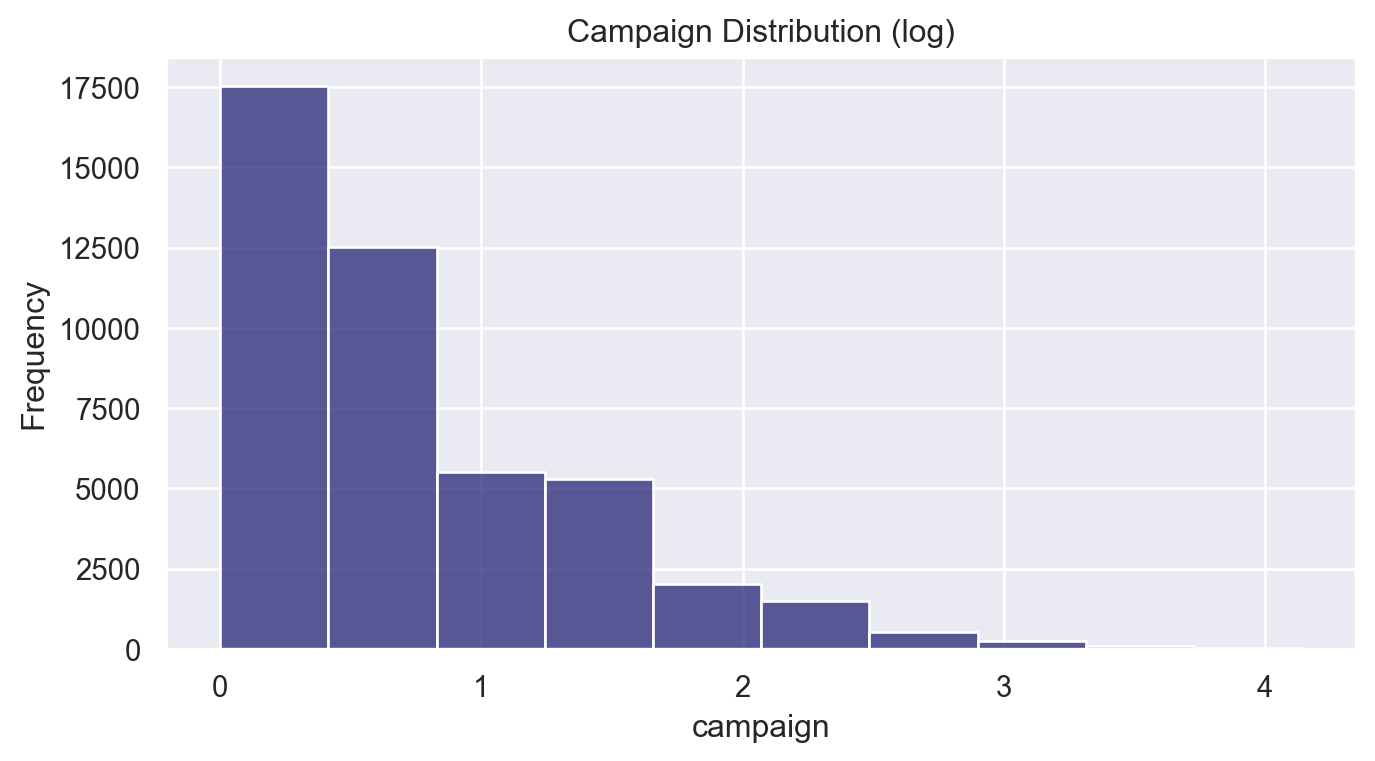

In [28]:
#Trying log-transformation
(so
 .Plot(df
       .campaign
       .transform(np.log))
 .add(so.Bars(color=color_palette[0]), so.Hist(bins=10))
 .label(x='campaign',
        y='Frequency',
        color=str.capitalize,
        title='Campaign Distribution (log)',)
 .on(matplotlib.figure.Figure(figsize=(8,4)))
 .plot()
)

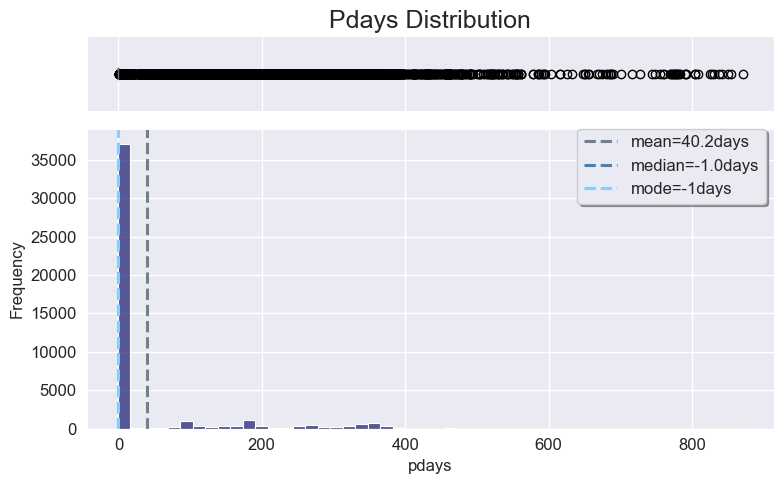

In [29]:
plot_continuous(df, 'pdays', 'Pdays Distribution', 'days')

In [30]:
loc_potential_outliers(df, "pdays")

Detected total of 11 potential outliers based on 1.5xIQR


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
44530,34,blue-collar,married,secondary,no,320,yes,no,cellular,12,aug,352,1,828,2,failure,1
44698,34,technician,married,secondary,no,384,yes,no,cellular,6,sep,127,2,831,1,other,0
44785,43,blue-collar,married,secondary,no,408,yes,no,unknown,14,sep,6,1,838,3,other,0
44829,37,management,divorced,tertiary,no,488,yes,no,cellular,17,sep,328,1,854,2,failure,1
44837,35,management,single,tertiary,no,151,no,no,unknown,20,sep,11,1,850,2,failure,0
44858,31,housemaid,married,secondary,no,243,yes,no,cellular,23,sep,305,2,842,1,failure,1
44924,35,blue-collar,married,secondary,no,137,no,yes,unknown,4,oct,5,1,808,12,failure,0
45024,47,admin.,married,secondary,no,1387,yes,no,cellular,14,oct,158,1,826,1,failure,0
45037,45,management,single,tertiary,no,2048,yes,no,cellular,18,oct,310,1,804,1,failure,1
45120,32,technician,married,secondary,no,1547,no,no,cellular,26,oct,289,1,805,4,other,1


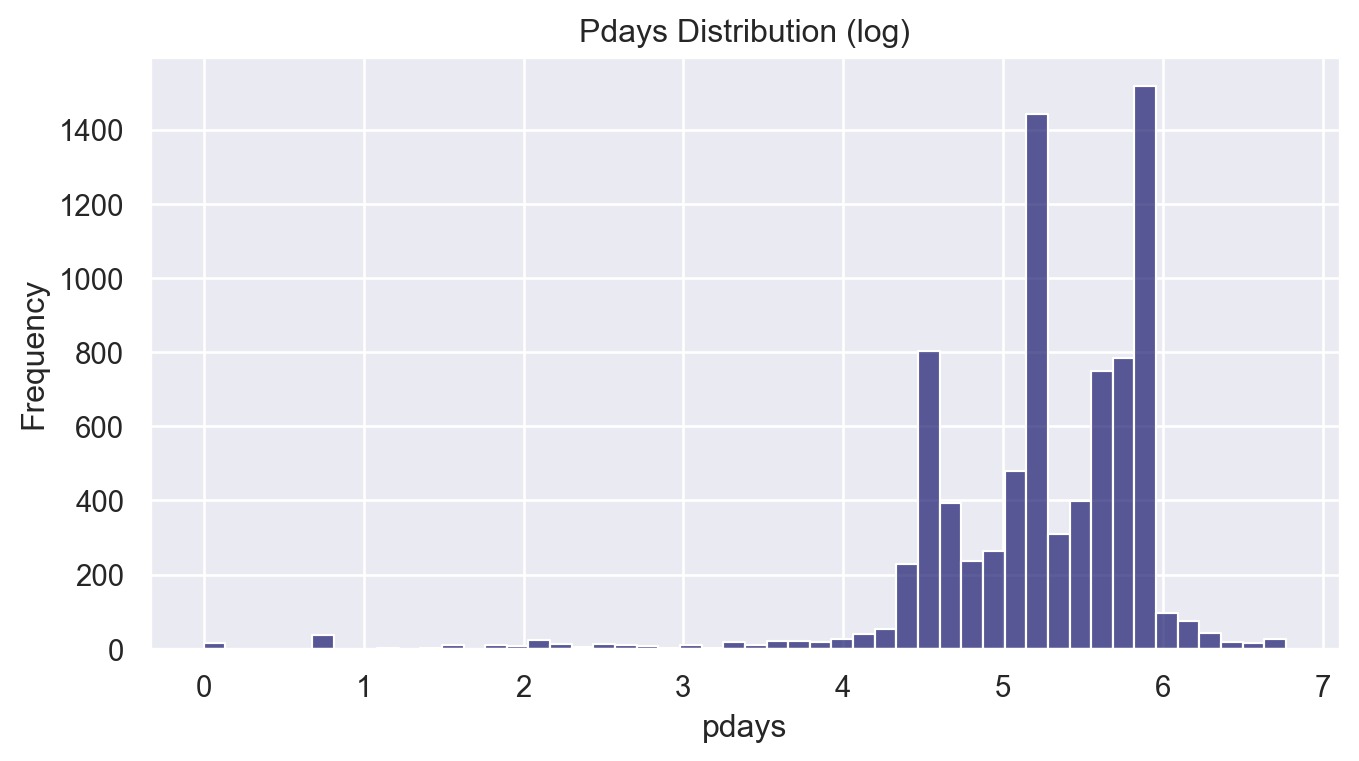

In [31]:
#Trying log-transformation
(so
 .Plot(df
       .pdays
       .transform(np.log))
 .add(so.Bars(color=color_palette[0]), so.Hist(bins=50))
 .label(x='pdays',
        y='Frequency',
        color=str.capitalize,
        title='Pdays Distribution (log)',)
 .on(matplotlib.figure.Figure(figsize=(8,4)))
 .plot()
)

In [32]:
(df
 .loc[df.pdays == -1]
)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45203,23,student,single,tertiary,no,113,no,no,cellular,17,nov,266,1,-1,0,unknown,1
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,-1,0,unknown,1
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1


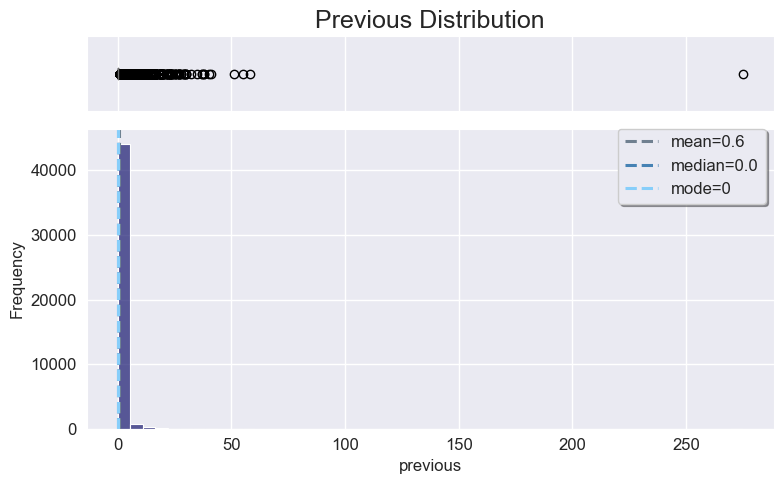

In [33]:
plot_continuous(df, 'previous', 'Previous Distribution', '')

In [34]:
loc_potential_outliers(df, "previous")

Detected total of 582 potential outliers based on 1.5xIQR


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
24136,34,management,married,tertiary,no,1770,yes,no,unknown,6,nov,26,1,101,11,other,0
24295,35,technician,divorced,tertiary,no,1718,yes,yes,cellular,17,nov,74,1,167,16,other,0
24331,36,management,married,tertiary,no,5057,yes,no,cellular,17,nov,70,1,166,10,failure,0
24506,42,unemployed,married,unknown,no,970,yes,no,telephone,17,nov,725,1,119,10,success,0
24556,44,management,married,tertiary,no,1451,yes,no,cellular,17,nov,157,3,150,12,failure,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45171,33,admin.,single,secondary,no,690,no,no,cellular,10,nov,223,3,555,16,failure,0
45172,30,technician,single,tertiary,no,2325,no,no,cellular,10,nov,134,1,92,8,success,0
45199,34,blue-collar,single,secondary,no,1475,yes,no,cellular,16,nov,1166,3,530,12,other,0
45204,73,retired,married,secondary,no,2850,no,no,cellular,17,nov,300,1,40,8,failure,1


### Univariate Analysis (Categorical)

In [35]:
cat_value_count(df, "job")

This categorical predictor has 12 unique values

                abs_count  norm_count    cumsum  mean_target
blue-collar       9732.0    0.215257  0.215257     0.072750
management        9458.0    0.209197  0.424454     0.137556
technician        7597.0    0.168034  0.592489     0.110570
admin.            5171.0    0.114375  0.706863     0.122027
services          4154.0    0.091880  0.798744     0.088830
retired           2264.0    0.050076  0.848820     0.227915
self-employed     1579.0    0.034925  0.883745     0.118429
entrepreneur      1487.0    0.032890  0.916635     0.082717
unemployed        1303.0    0.028820  0.945456     0.155027
housemaid         1240.0    0.027427  0.972883     0.087903
student            938.0    0.020747  0.993630     0.286780
unknown            288.0    0.006370  1.000000     0.118056


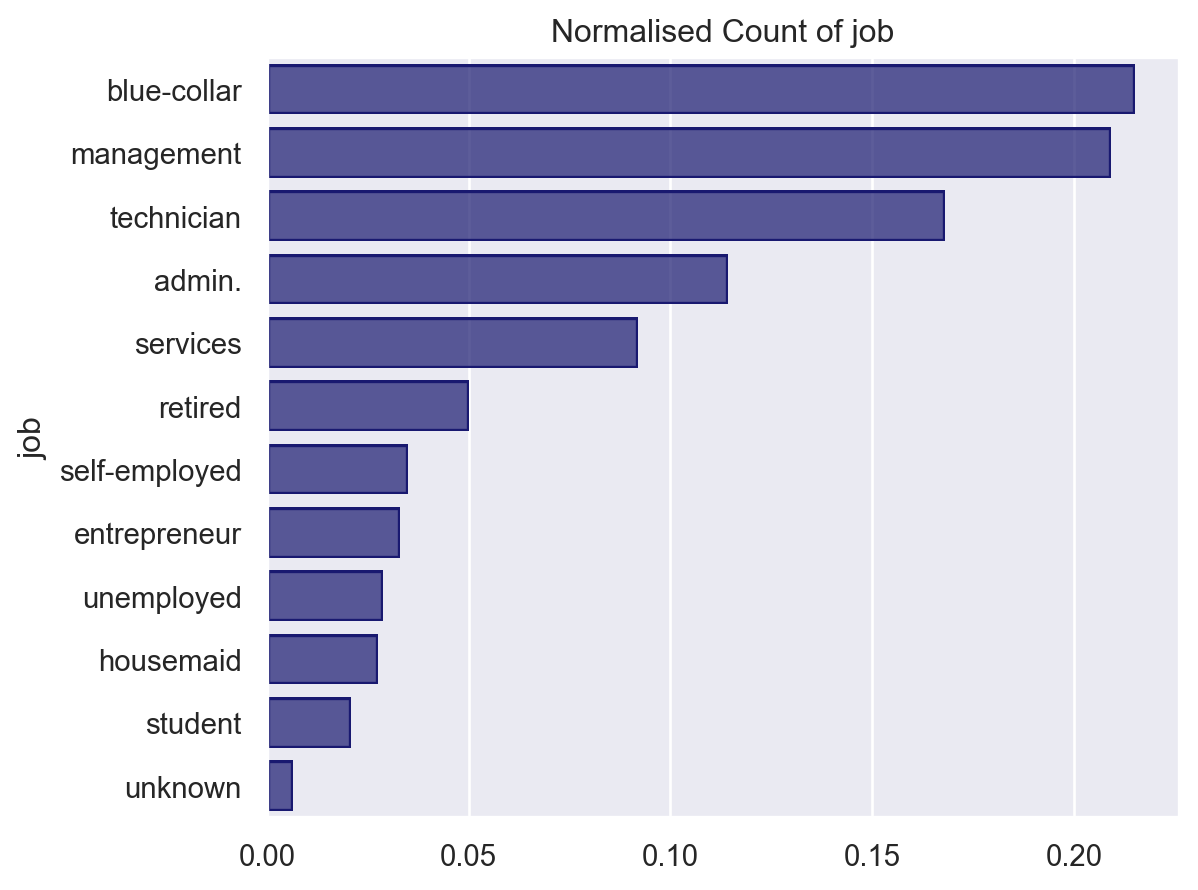

In [36]:
plot_categorical(df, "job")

In [37]:
cat_value_count(df, "marital")

This categorical predictor has 3 unique values

           abs_count  norm_count    cumsum  mean_target
married     27214.0    0.601933  0.601933     0.101235
single      12790.0    0.282896  0.884829     0.149492
divorced     5207.0    0.115171  1.000000     0.119455


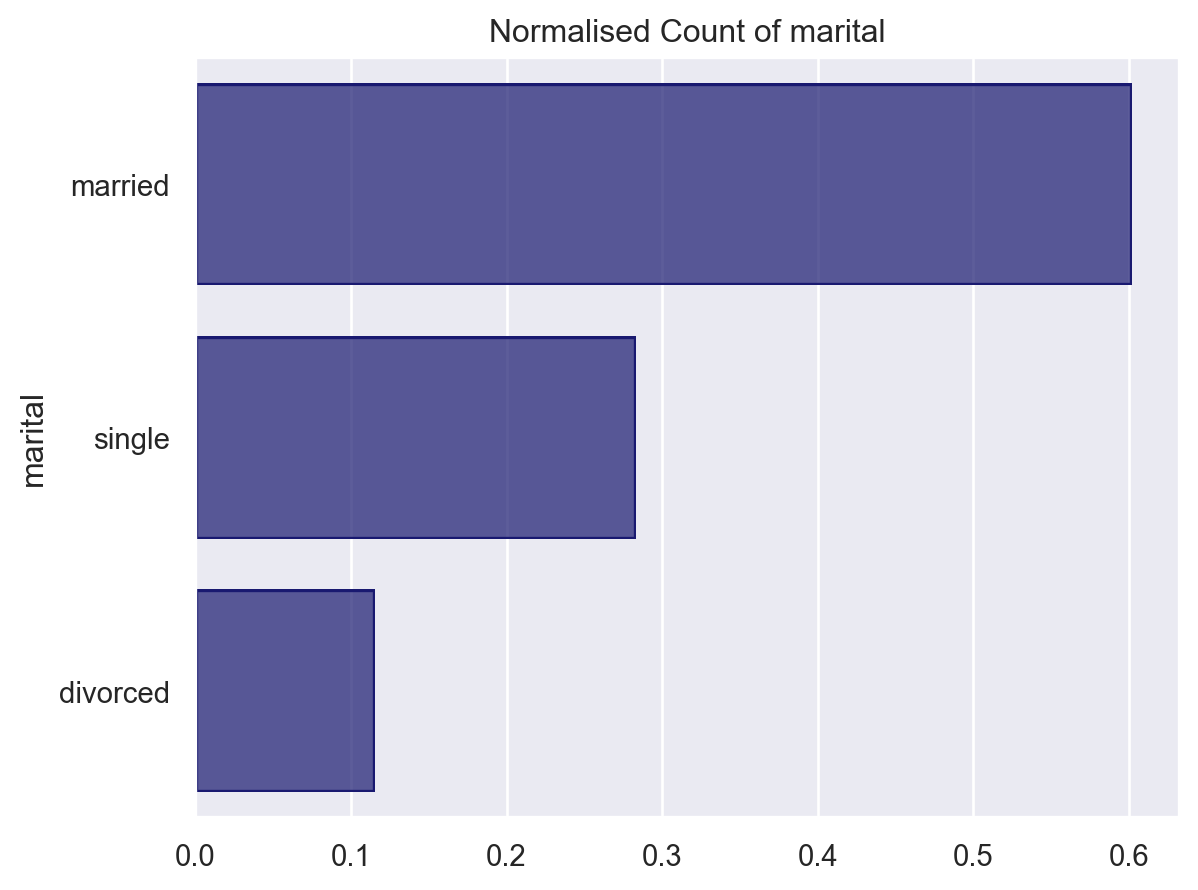

In [38]:
plot_categorical(df, "marital")

In [39]:
cat_value_count(df, "education")

This categorical predictor has 4 unique values

            abs_count  norm_count    cumsum  mean_target
secondary    23202.0    0.513194  0.513194     0.105594
tertiary     13301.0    0.294198  0.807392     0.150064
primary       6851.0    0.151534  0.958926     0.086265
unknown       1857.0    0.041074  1.000000     0.135703


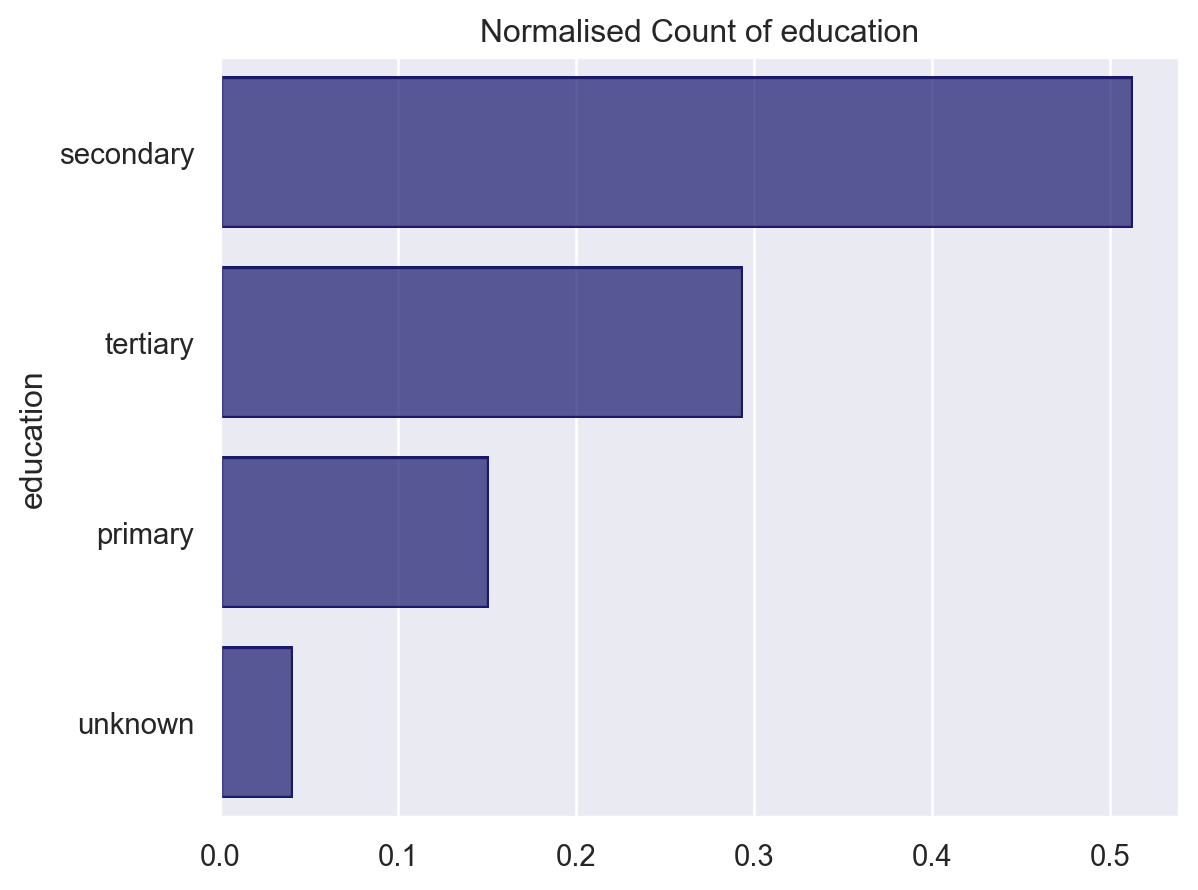

In [40]:
plot_categorical(df, "education")

In [41]:
cat_value_count(df, "default")

This categorical predictor has 2 unique values

      abs_count  norm_count    cumsum  mean_target
no     44396.0    0.981973  0.981973     0.117961
yes      815.0    0.018027  1.000000     0.063804


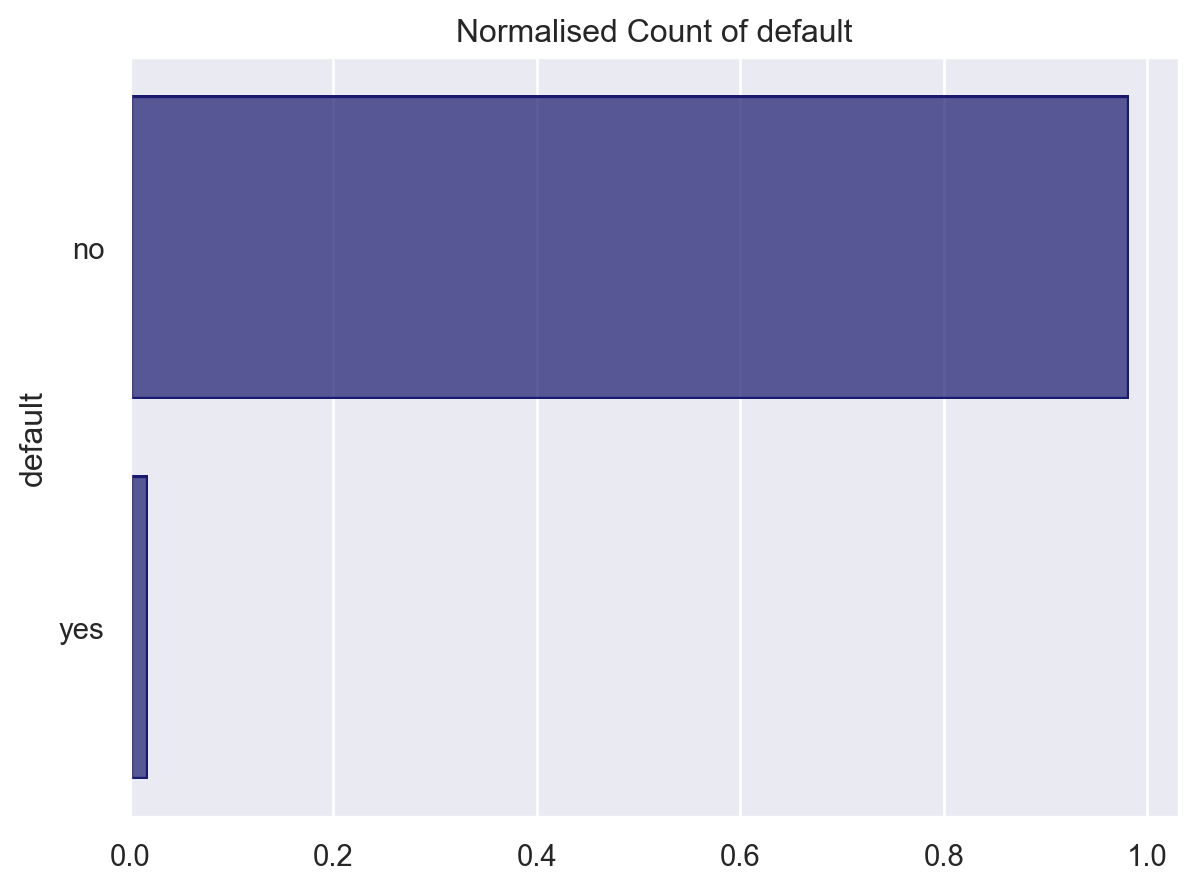

In [42]:
plot_categorical(df, "default")

In [43]:
cat_value_count(df, "housing")

This categorical predictor has 2 unique values

      abs_count  norm_count    cumsum  mean_target
yes    25130.0    0.555838  0.555838     0.077000
no     20081.0    0.444162  1.000000     0.167024


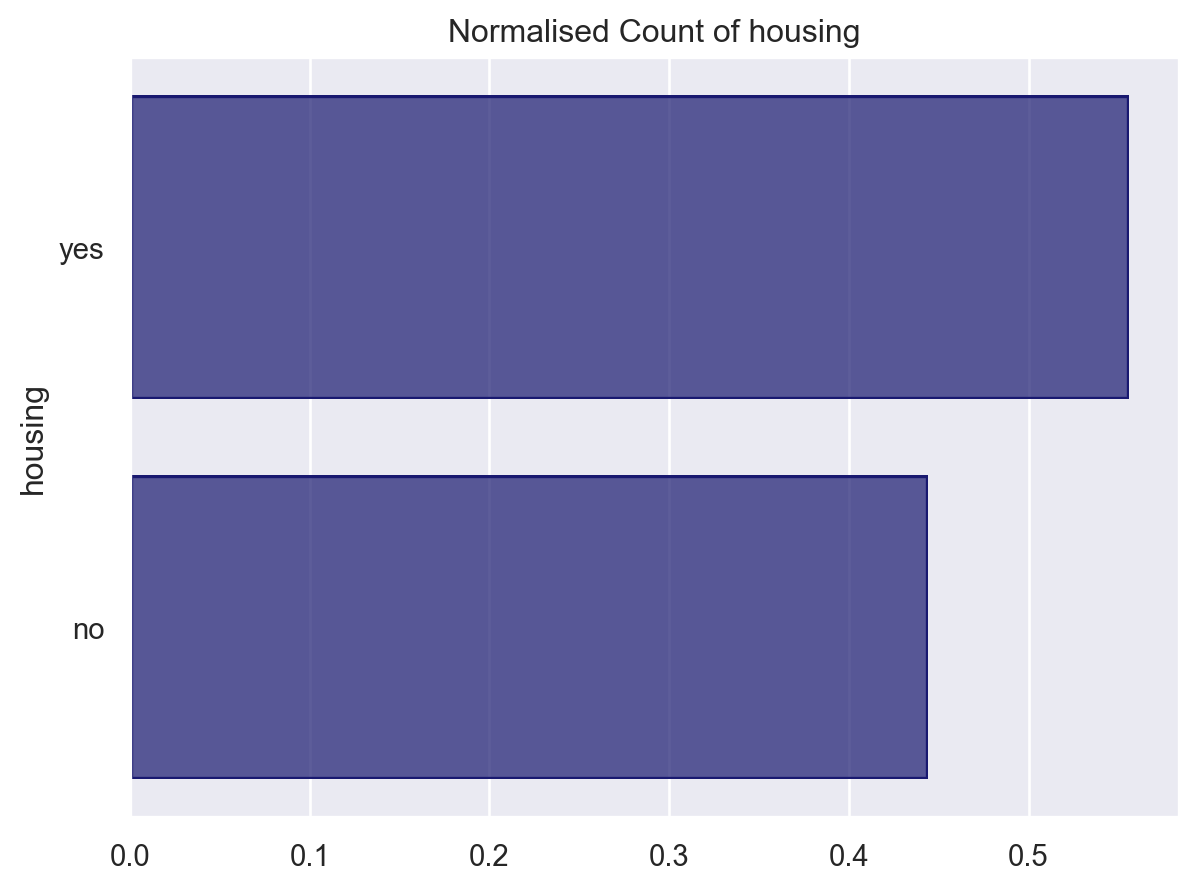

In [44]:
plot_categorical(df, "housing")

In [45]:
cat_value_count(df, "loan")

This categorical predictor has 2 unique values

      abs_count  norm_count    cumsum  mean_target
no     37967.0    0.839774  0.839774     0.126557
yes     7244.0    0.160226  1.000000     0.066814


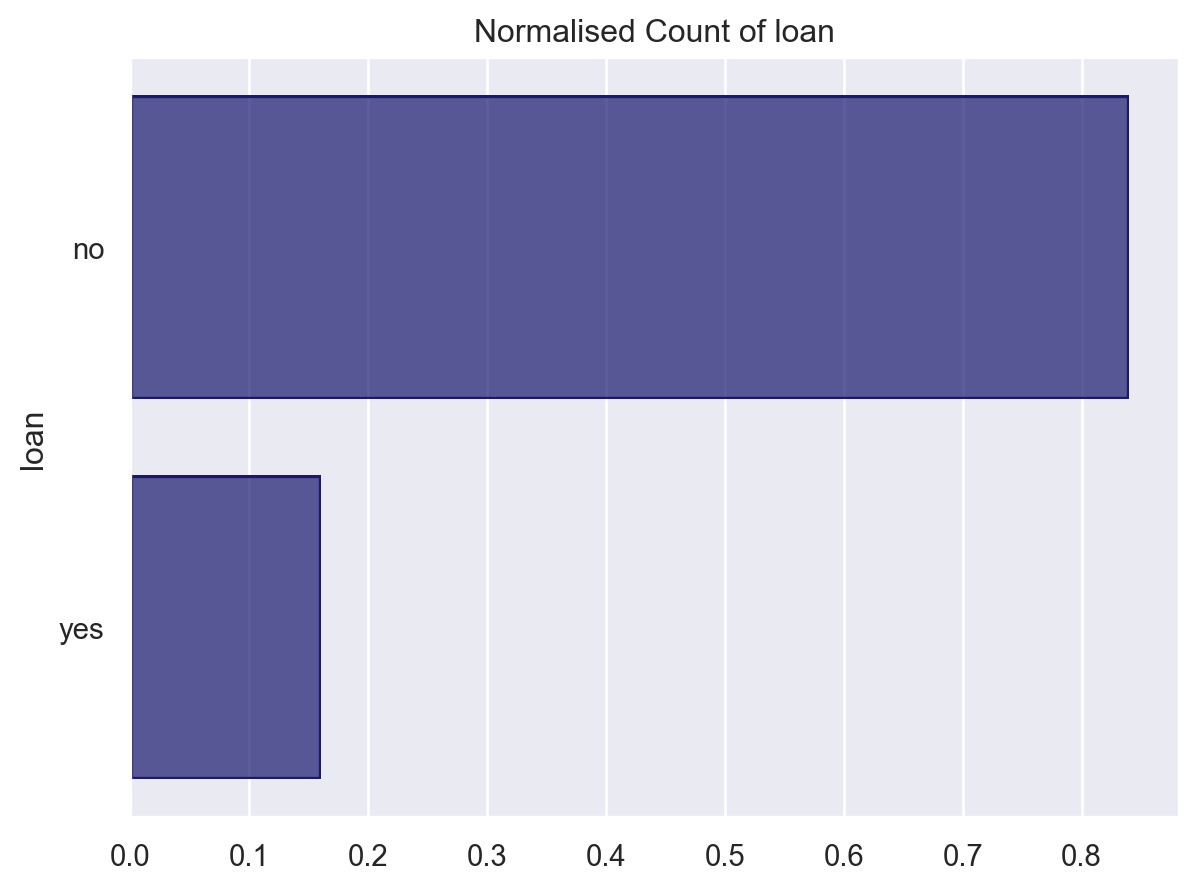

In [46]:
plot_categorical(df, "loan")

In [47]:
cat_value_count(df, "contact")

This categorical predictor has 3 unique values

            abs_count  norm_count    cumsum  mean_target
cellular     29285.0    0.647741  0.647741     0.149189
unknown      13020.0    0.287983  0.935724     0.040707
telephone     2906.0    0.064276  1.000000     0.134205


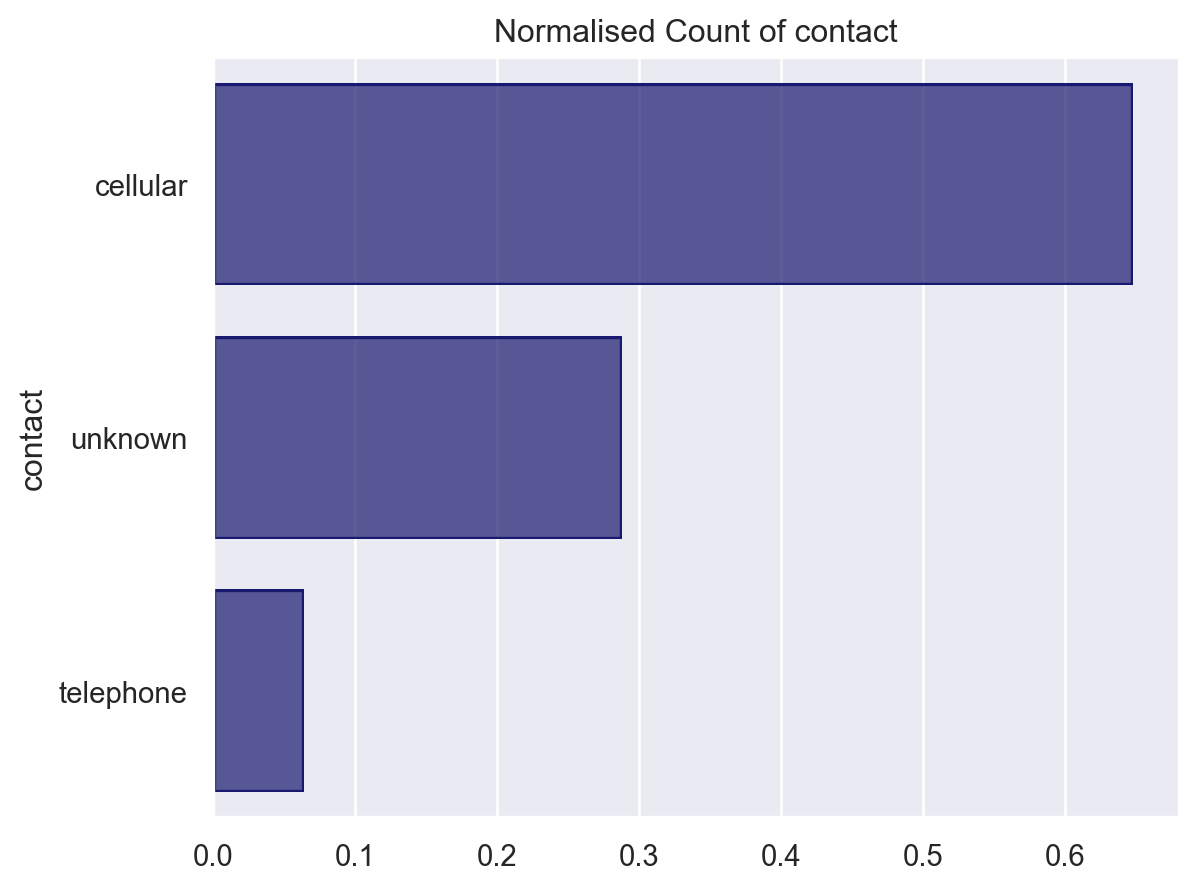

In [48]:
plot_categorical(df, "contact")

In [49]:
cat_value_count(df,
                'month',
                reindex=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

This categorical predictor has 12 unique values

      abs_count  norm_count    cumsum  mean_target
jan     1403.0    0.031032  0.031032     0.101212
feb     2649.0    0.058592  0.089624     0.166478
mar      477.0    0.010551  0.100175     0.519916
apr     2932.0    0.064851  0.165026     0.196794
may    13766.0    0.304483  0.469510     0.067195
jun     5341.0    0.118135  0.587645     0.102228
jul     6895.0    0.152507  0.740152     0.090935
aug     6247.0    0.138174  0.878326     0.110133
sep      579.0    0.012807  0.891133     0.464594
oct      738.0    0.016323  0.907456     0.437669
nov     3970.0    0.087810  0.995267     0.101511
dec      214.0    0.004733  1.000000     0.467290


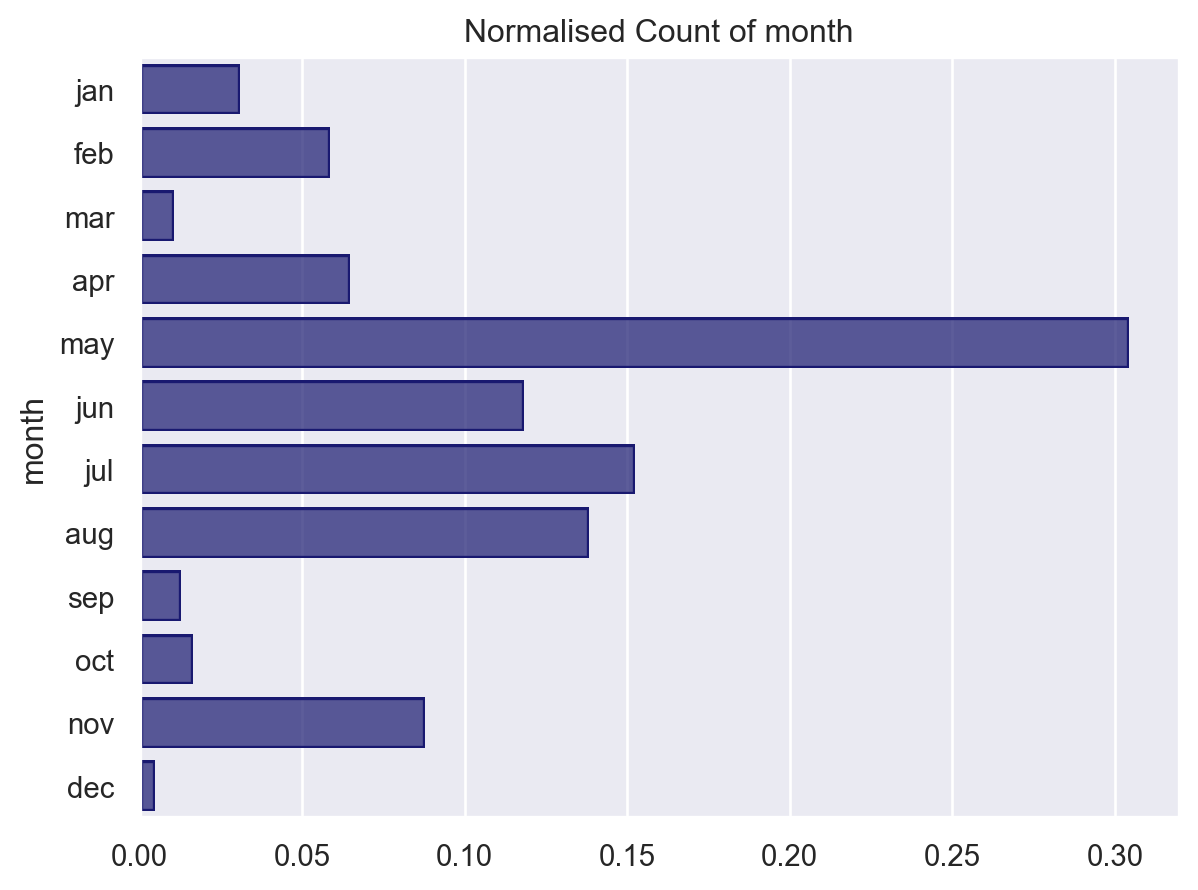

In [50]:
plot_categorical(df, "month", ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

In [51]:
cat_value_count(df, "poutcome")

This categorical predictor has 4 unique values

          abs_count  norm_count    cumsum  mean_target
unknown    36959.0    0.817478  0.817478     0.091615
failure     4901.0    0.108403  0.925881     0.126097
other       1840.0    0.040698  0.966579     0.166848
success     1511.0    0.033421  1.000000     0.647253


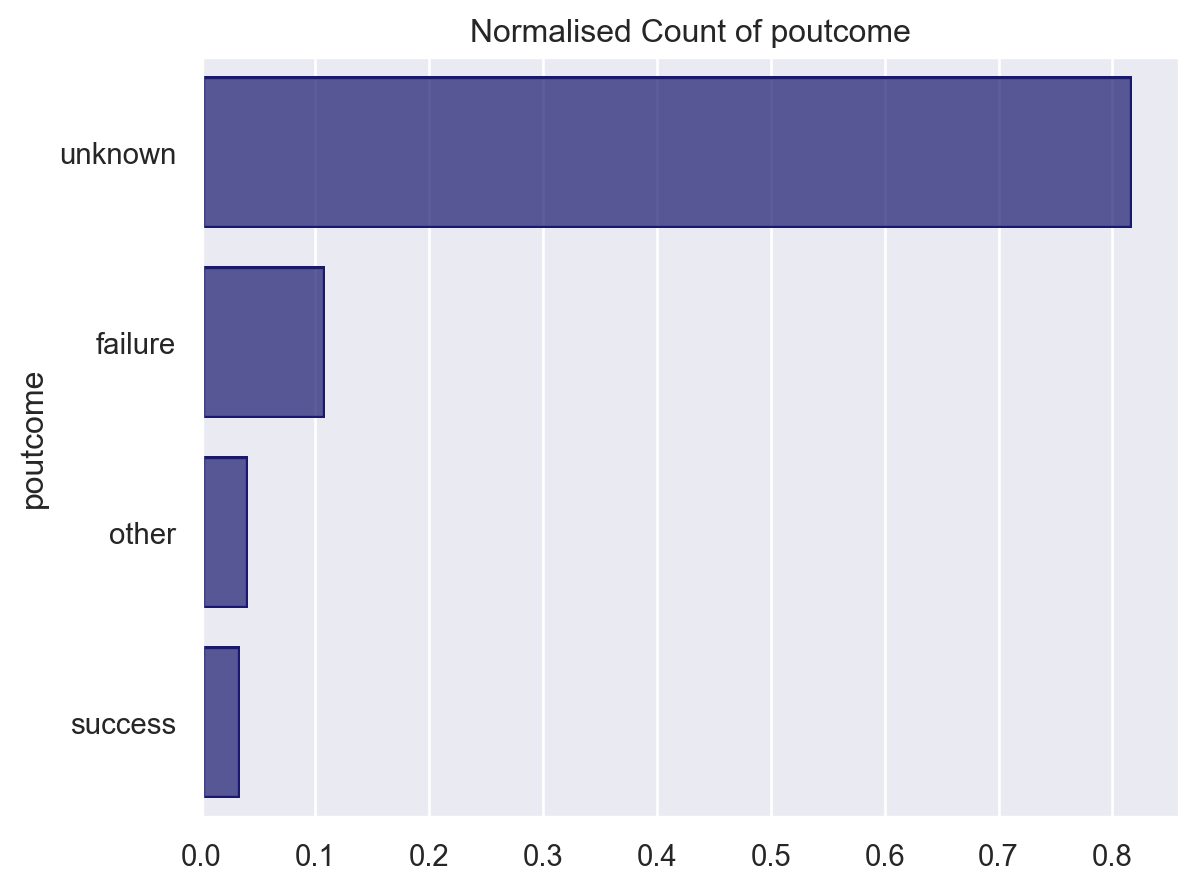

In [52]:
plot_categorical(df, "poutcome")

### Bivariate Analysis (Numerical Features v Label)

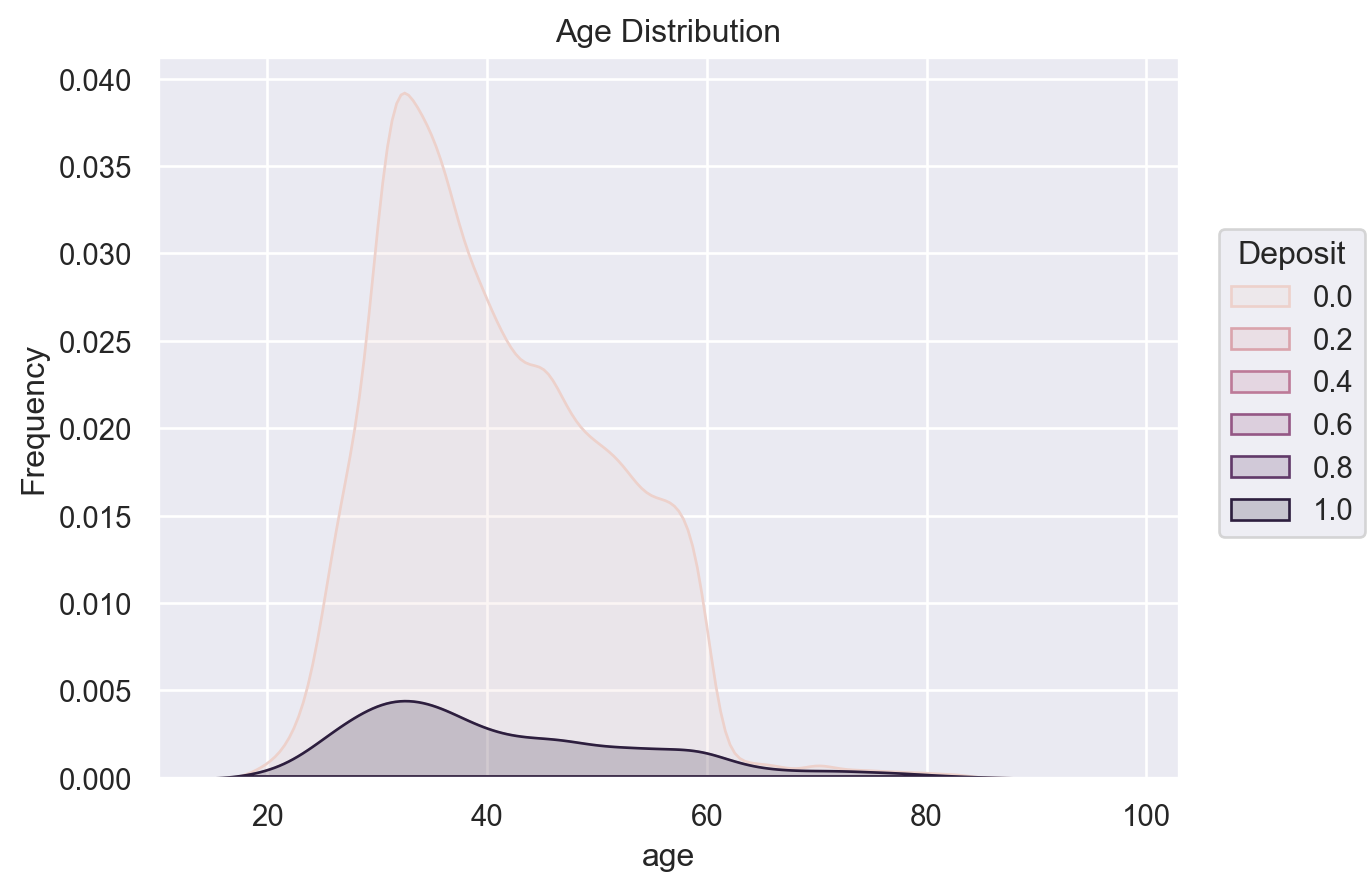

In [53]:
(so
 .Plot(df, x='age', color='deposit')
 .add(so.Area(), 
      so.KDE())
 .label(x='age',
        y='Frequency',
        color=str.capitalize,
        title='Age Distribution')
)

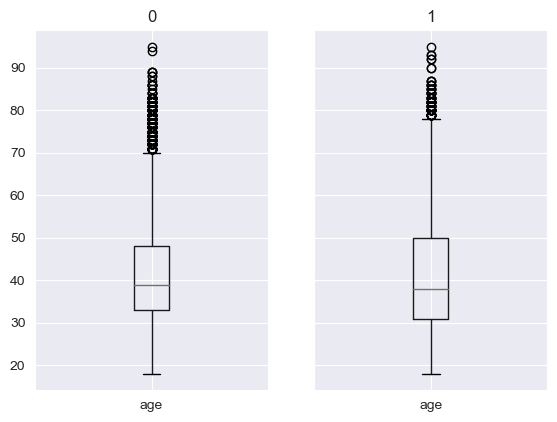

In [54]:
(df
 .groupby('deposit')
 .boxplot(column=['age'])
);

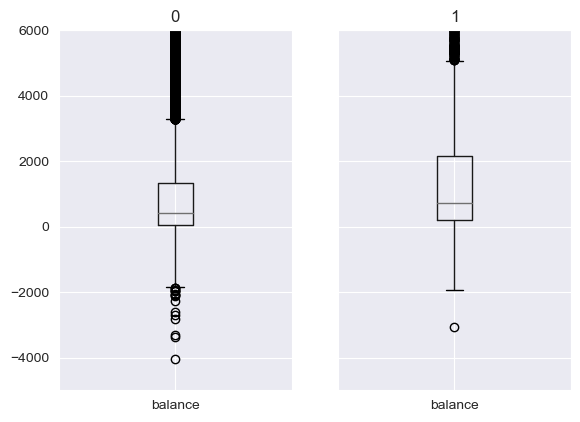

In [55]:
(df
 .groupby('deposit')
 .boxplot(column=['balance'])
)
plt.ylim(-5000,6000);

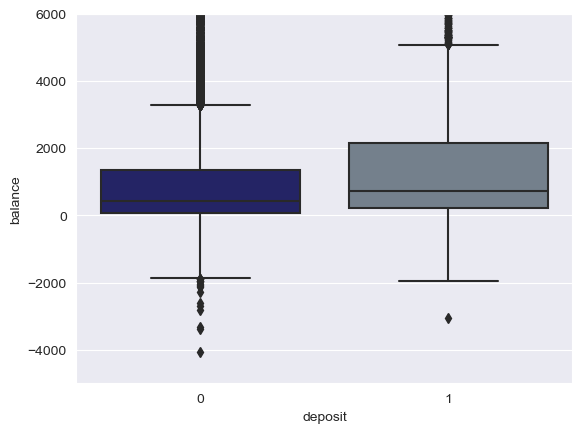

In [56]:
fig, ax = plt.subplots()
fig = (sns
       .boxplot(df,
                x='deposit',
                y='balance',
                orient='v',)
       .figure
      )
ax.set_ylim(-5000,6000);

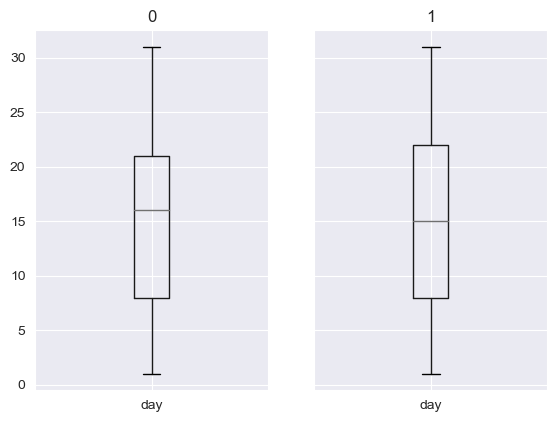

In [57]:
(df
 .groupby('deposit')
 .boxplot(column=['day'])
);

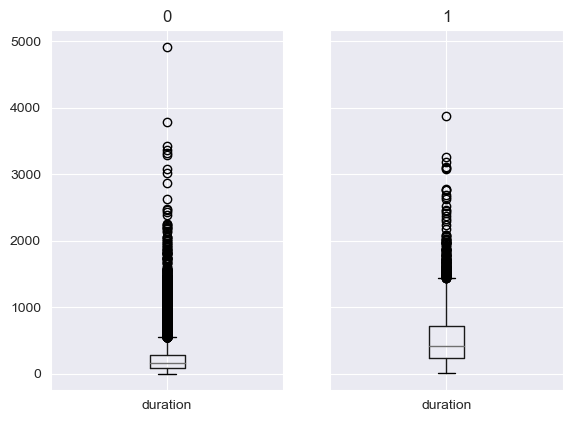

In [58]:
(df
 .groupby('deposit')
 .boxplot(column=['duration'])
);

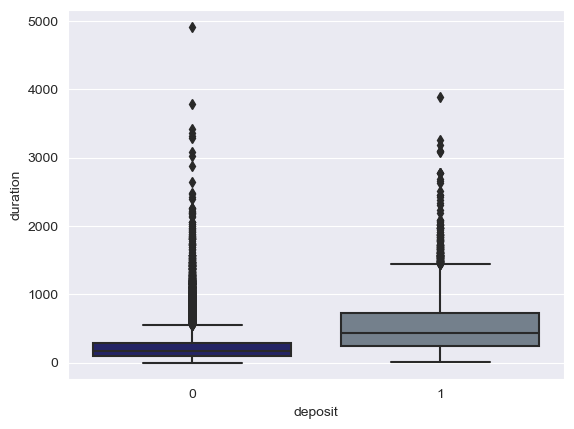

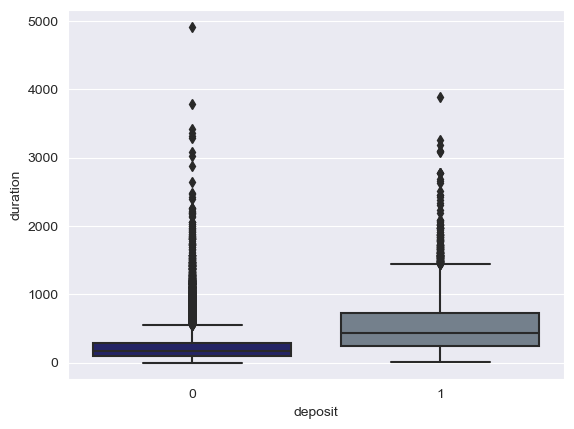

In [59]:
fig, ax = plt.subplots()
fig = (sns
       .boxplot(df,
                x='deposit',
                y='duration',
                orient='v',)
       .figure
      )
fig

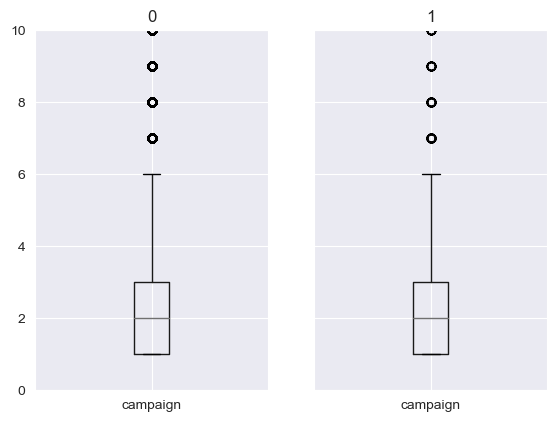

In [60]:
(df
 .groupby('deposit')
 .boxplot(column=['campaign'])
)
plt.ylim(0, 10);

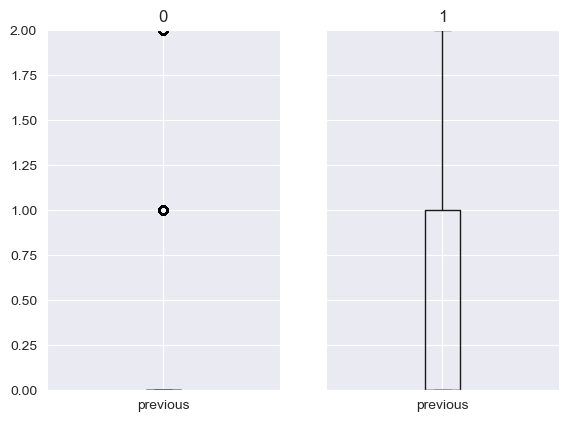

In [61]:
(df
 .groupby('deposit')
 .boxplot(column=['previous'])
)
plt.ylim(0,2);

### Bivariate Analysis (Categorical Features v Label)

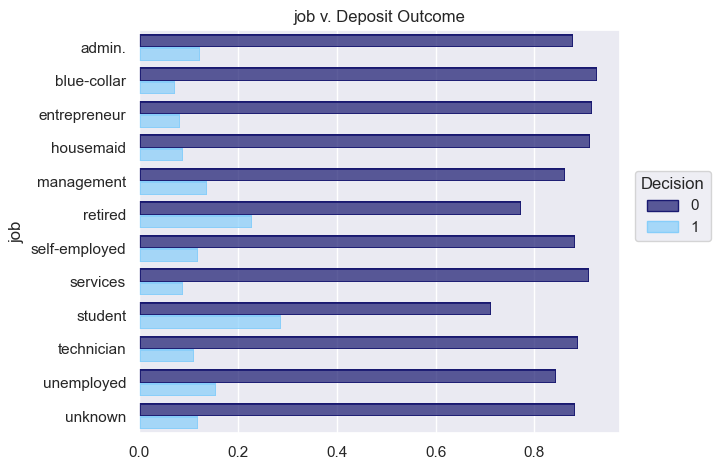

In [62]:
plot_features_label(df, "job")

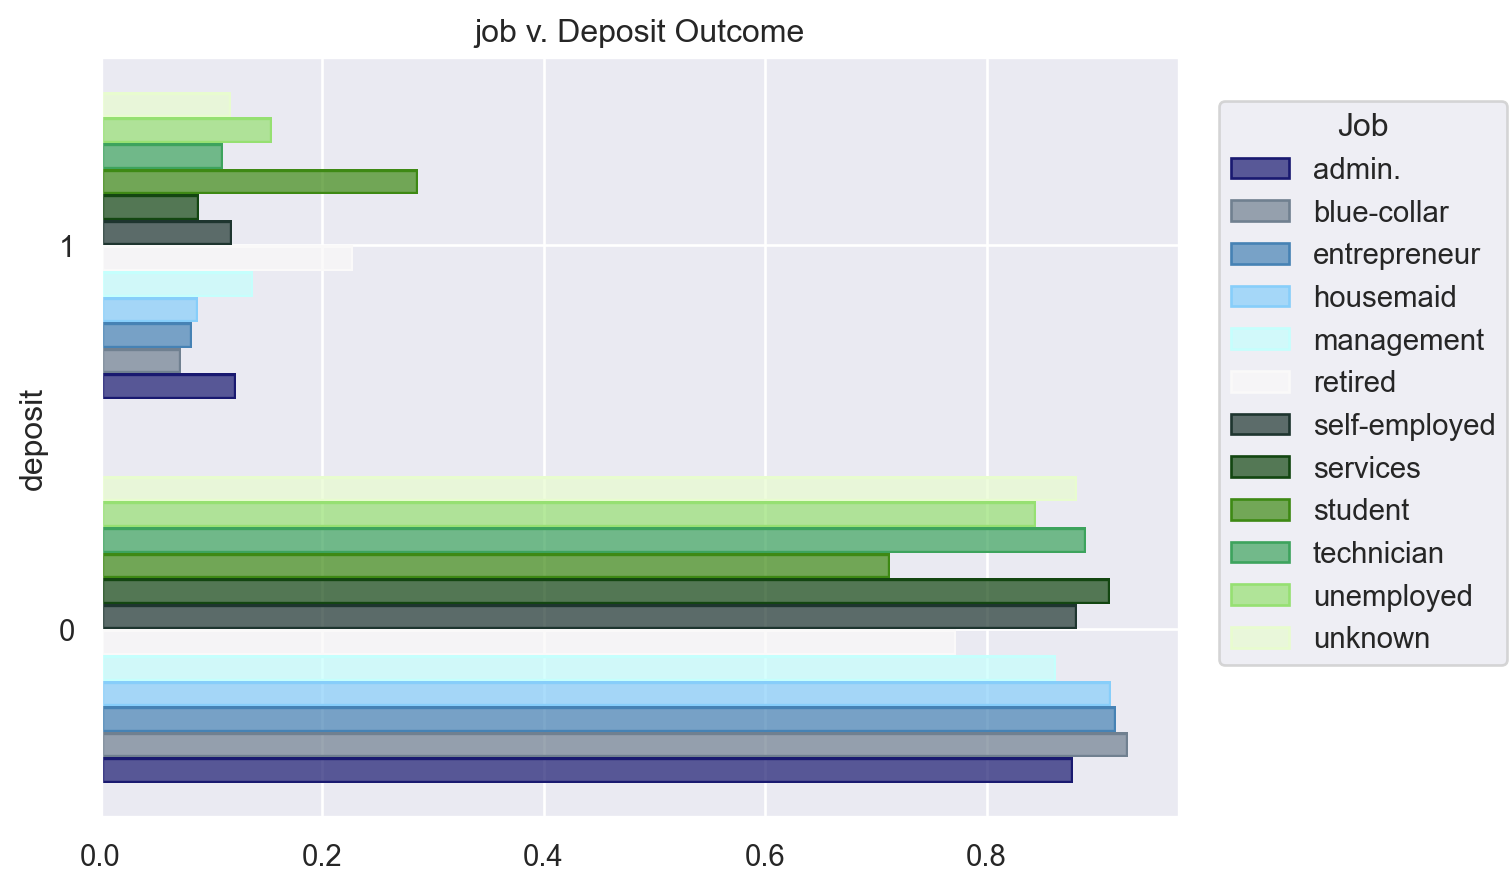

In [63]:
plot_label_features(df, "job")

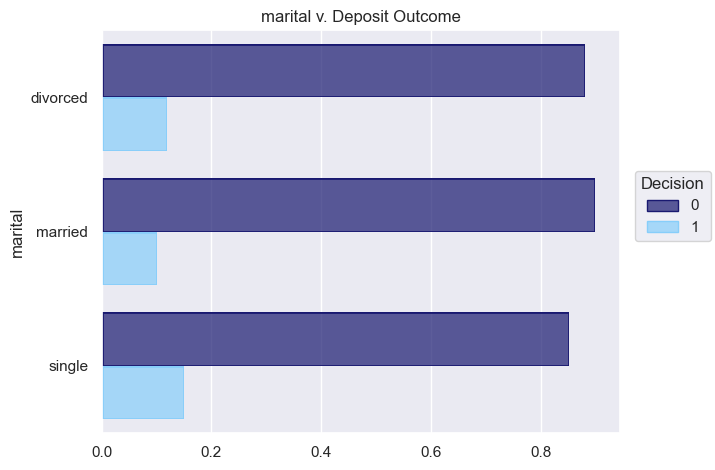

In [64]:
plot_features_label(df, "marital")

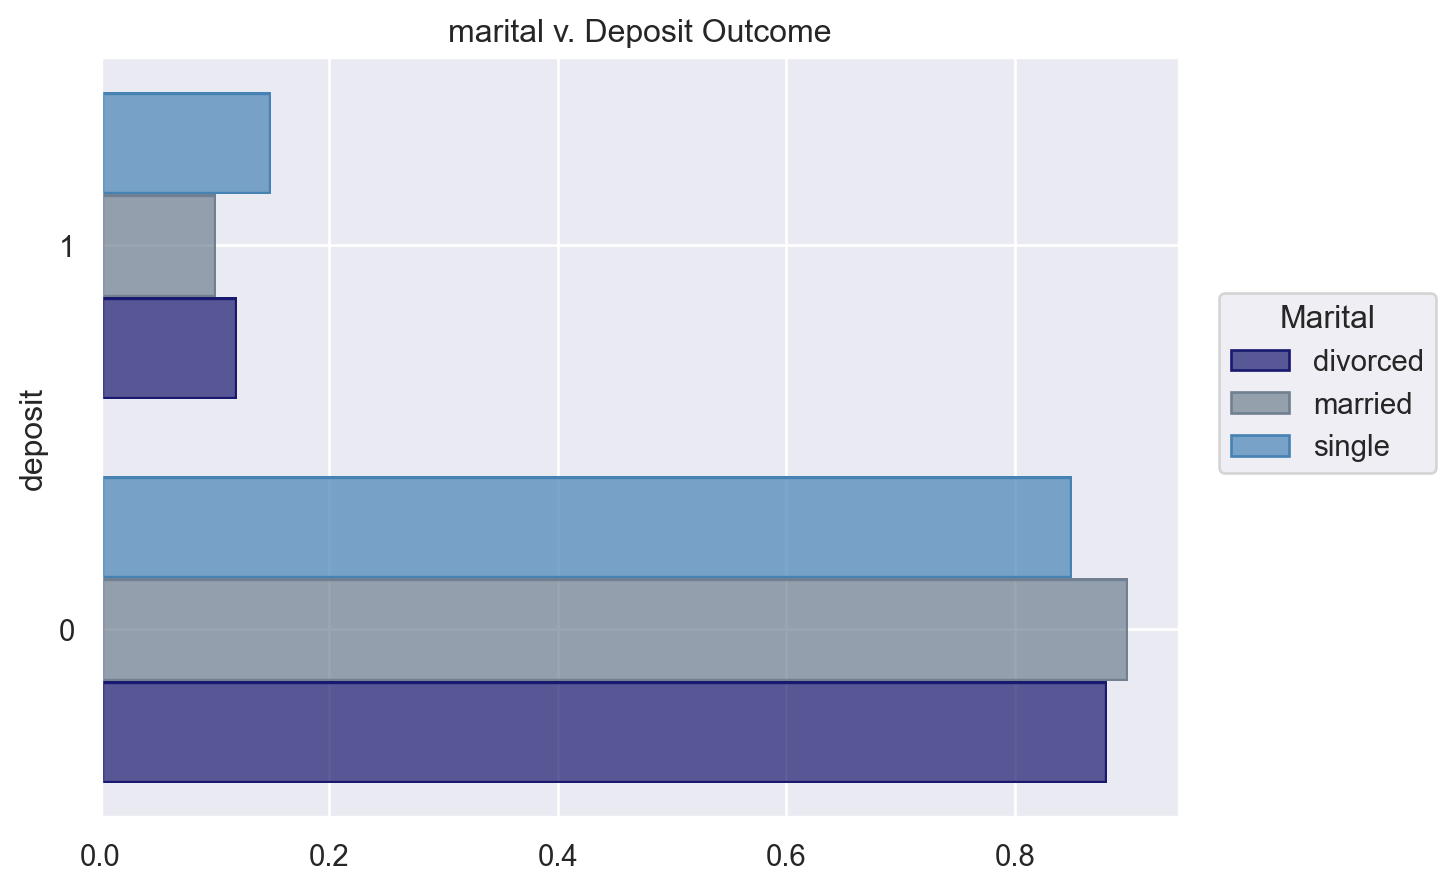

In [65]:
plot_label_features(df, "marital")

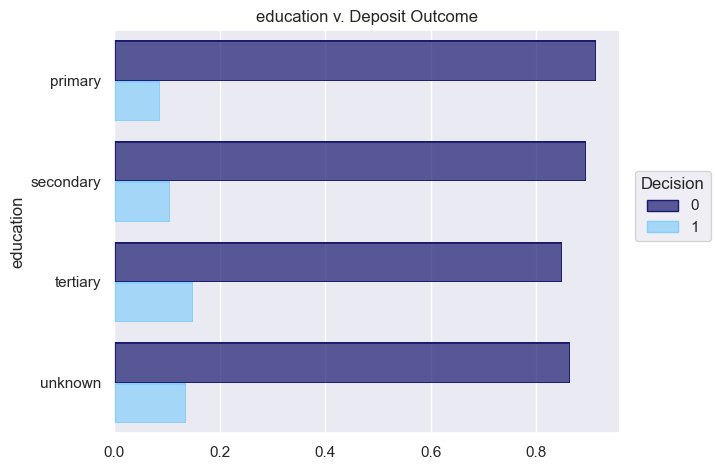

In [66]:
plot_features_label(df, "education")

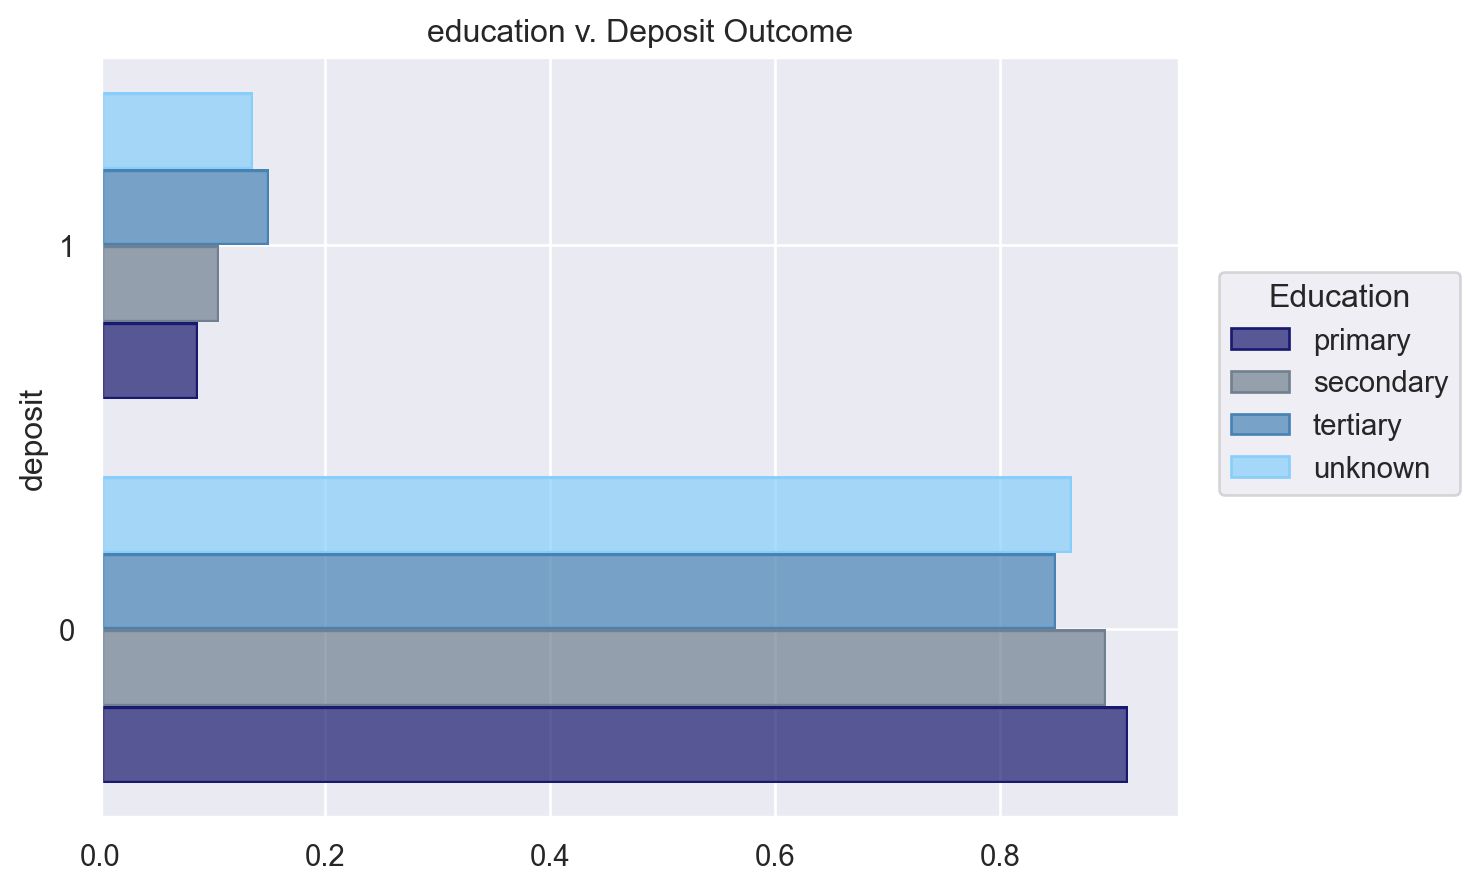

In [67]:
plot_label_features(df, "education")

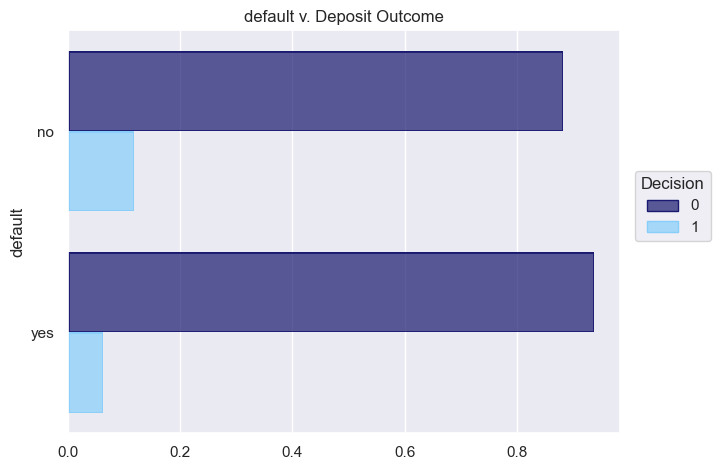

In [68]:
plot_features_label(df, "default")

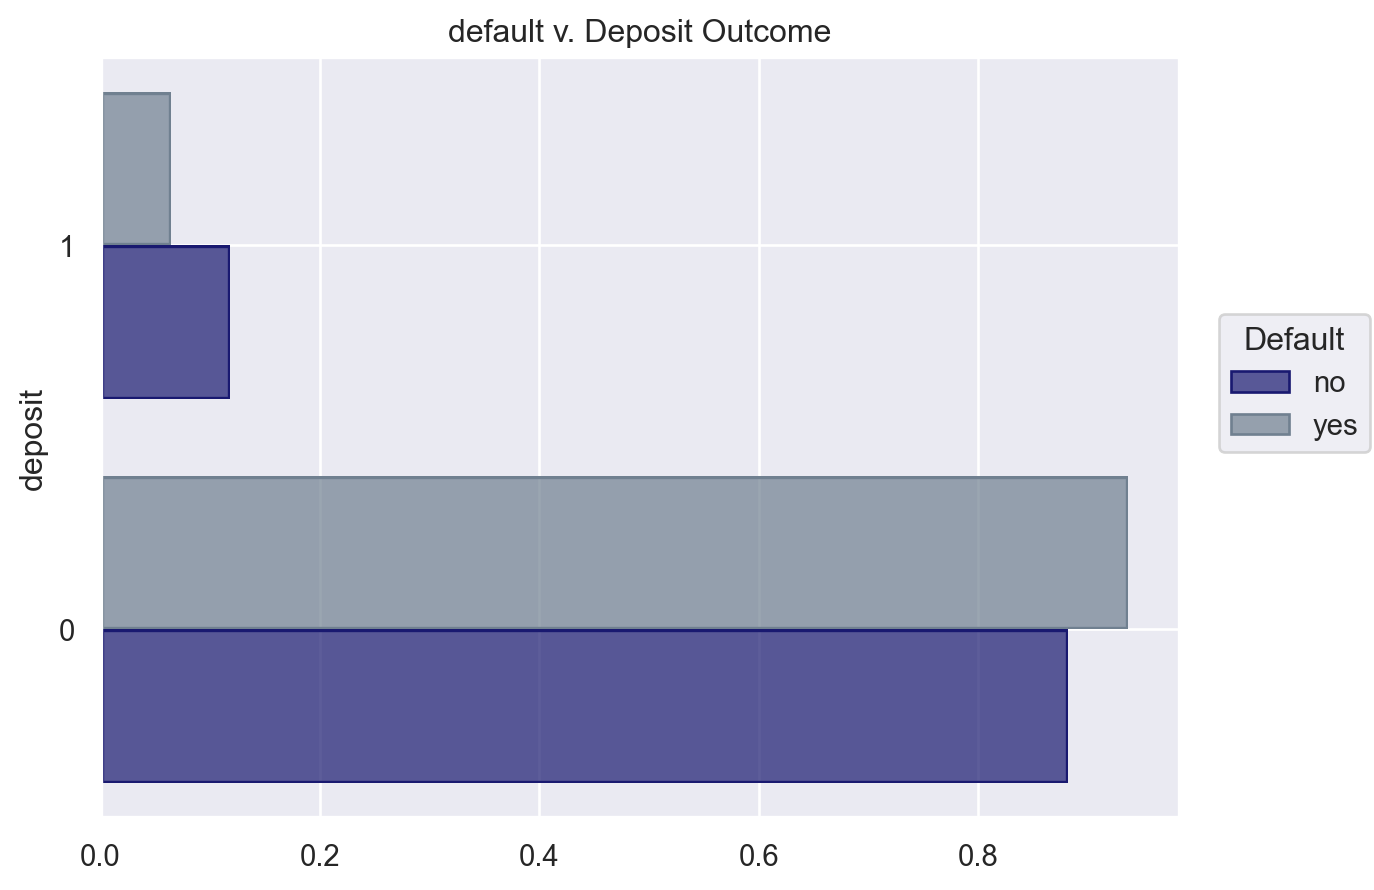

In [69]:
plot_label_features(df, "default")

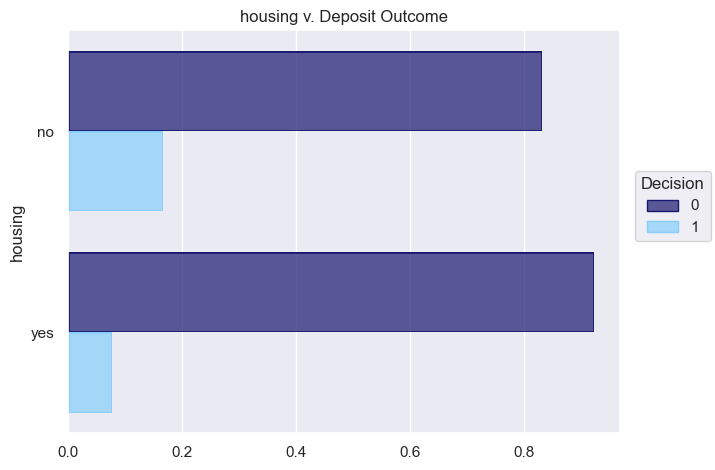

In [70]:
plot_features_label(df, "housing")

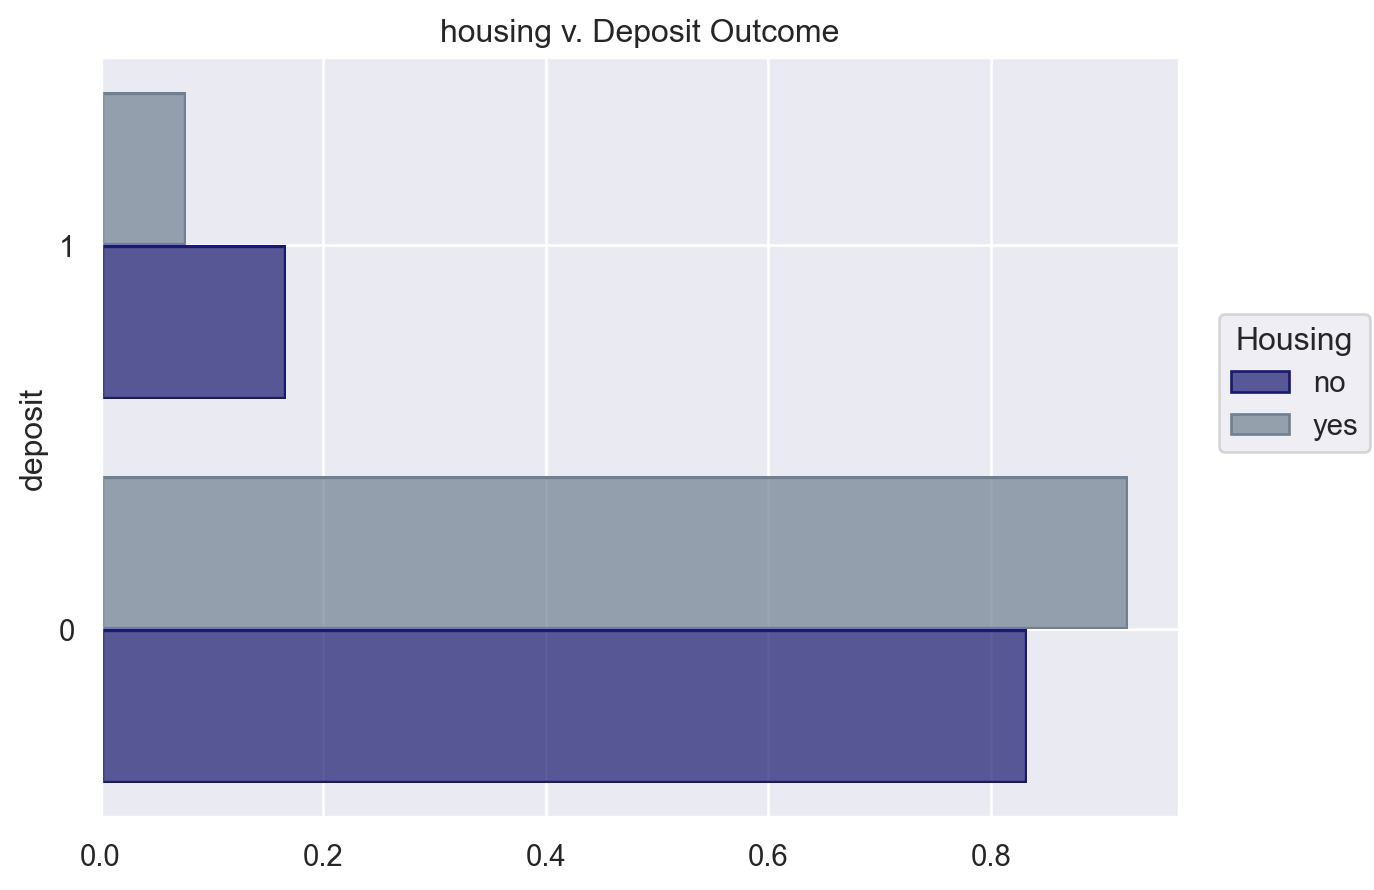

In [71]:
plot_label_features(df, "housing")

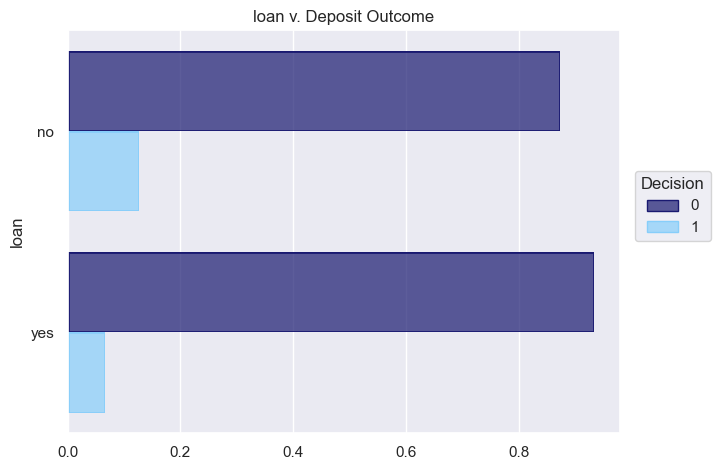

In [72]:
plot_features_label(df, "loan")

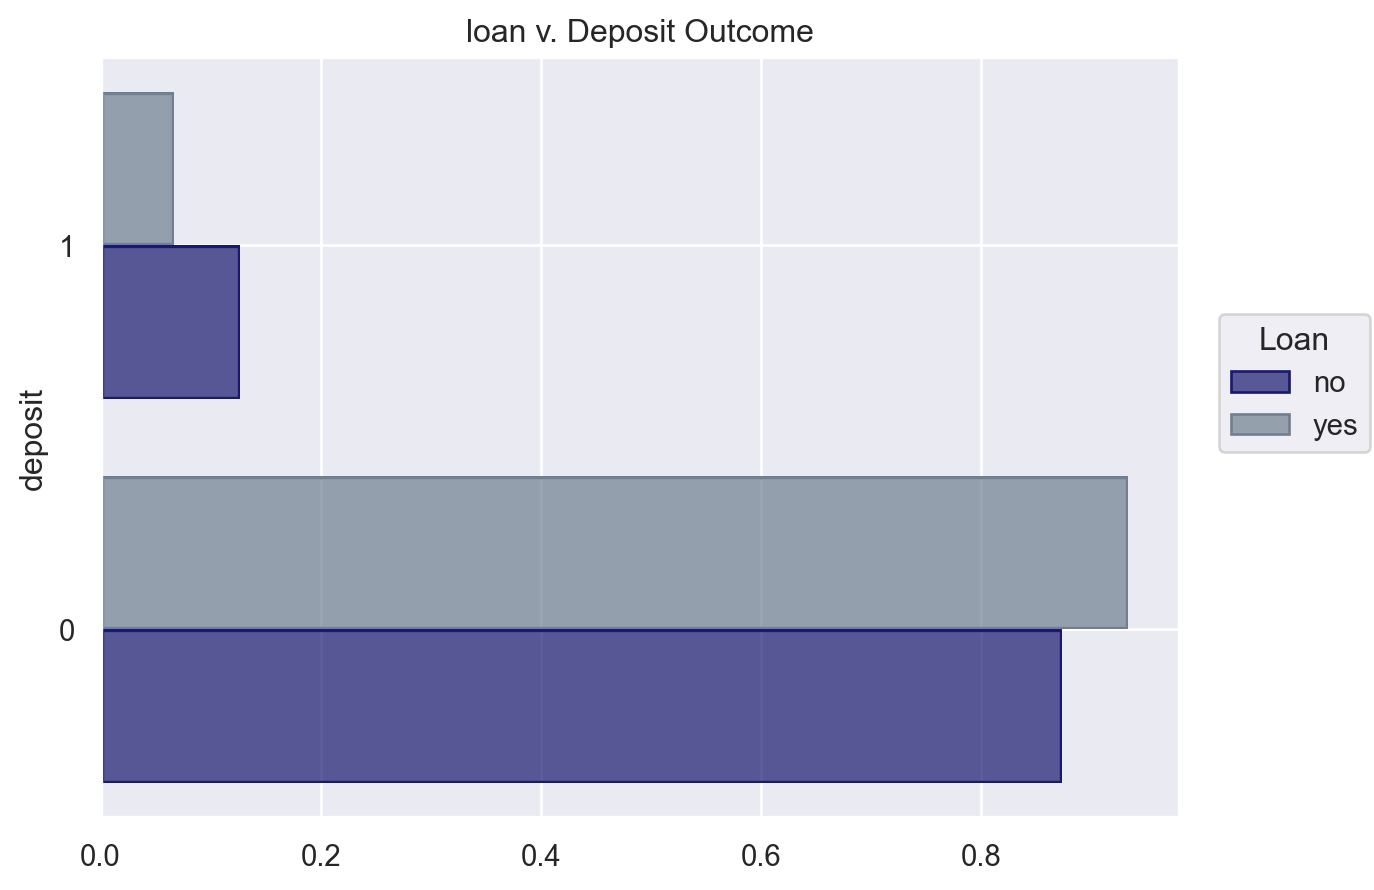

In [73]:
plot_label_features(df, "loan")

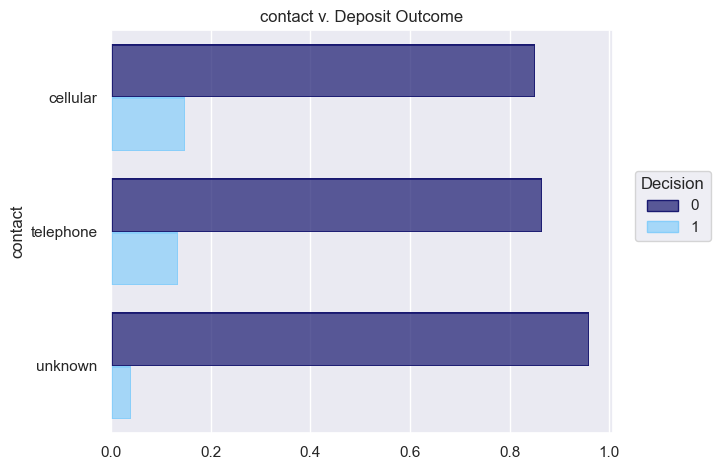

In [74]:
plot_features_label(df, "contact")

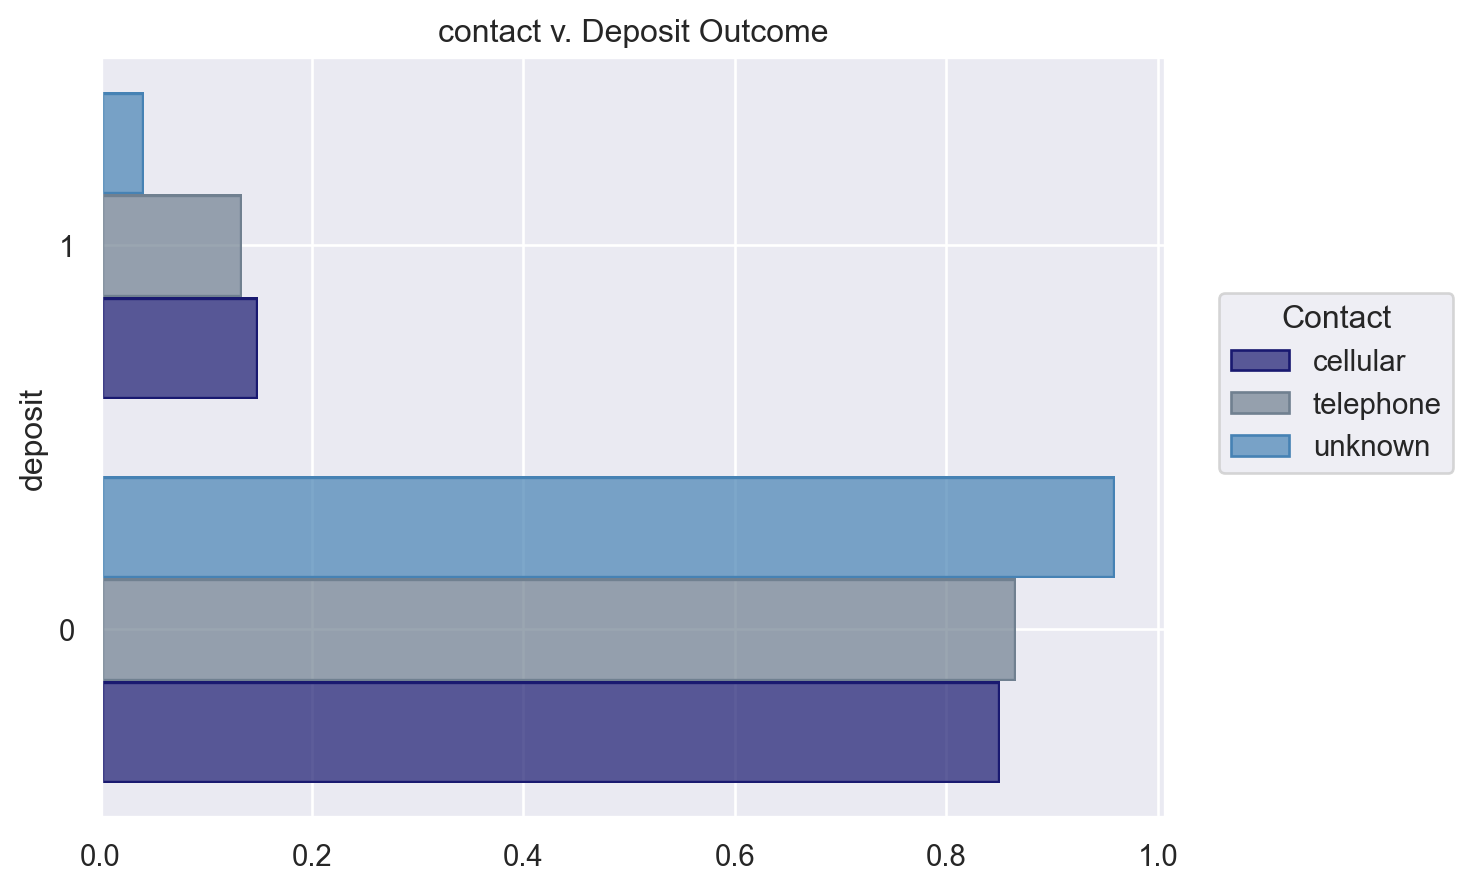

In [75]:
plot_label_features(df, "contact")

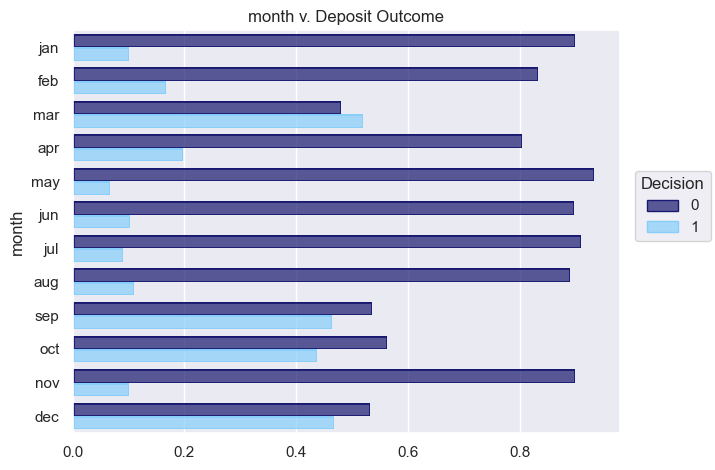

In [76]:
plot_features_label(df, "month", ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

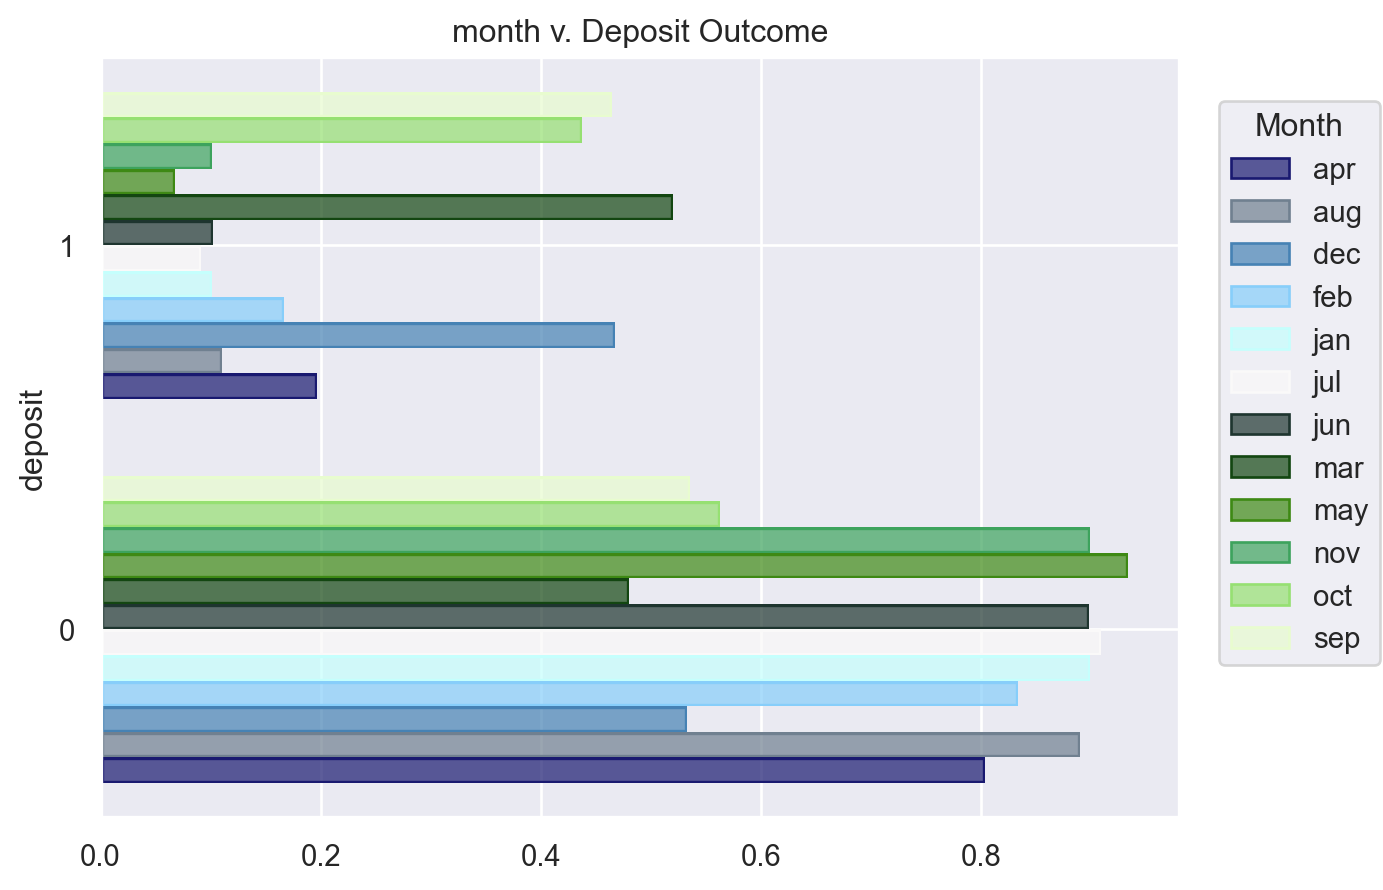

In [77]:
plot_label_features(df, "month")

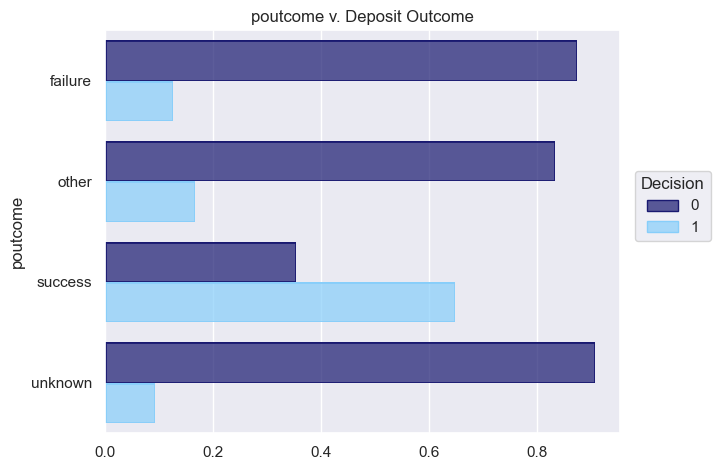

In [78]:
plot_features_label(df, "poutcome")

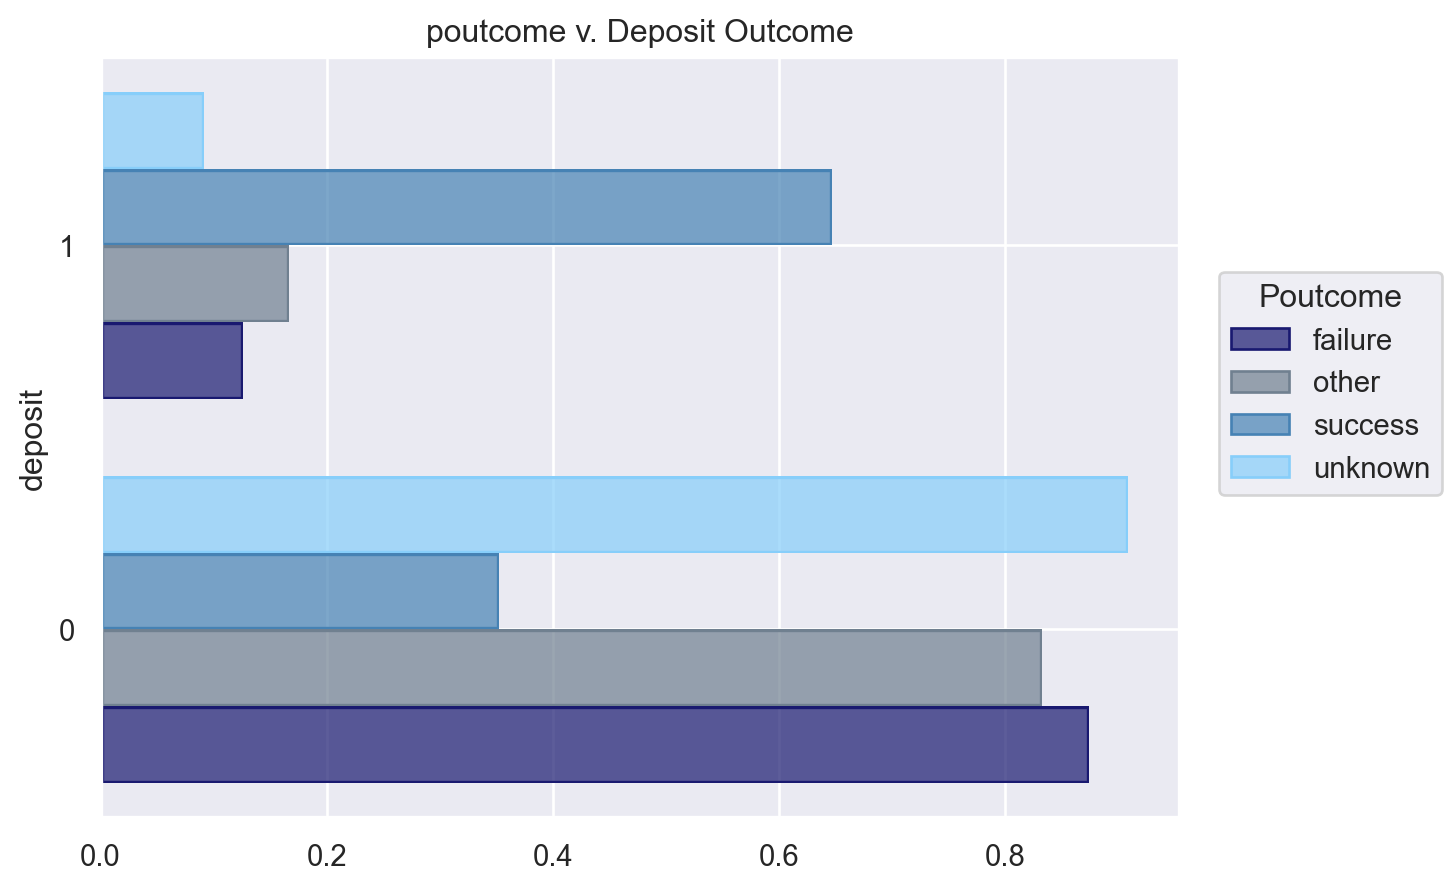

In [79]:
plot_label_features(df, "poutcome")

In [80]:
(df
 .select_dtypes('int')
 .corr(method='spearman')
 .style
 .background_gradient(cmap="viridis", axis=None)
 .set_sticky(axis="index")
 .set_sticky(axis="columns")
)

,age,balance,day,duration,campaign,pdays,previous,deposit
age,1.000000,0.096380,-0.008948,-0.033257,0.037136,-0.017468,-0.011900,-0.008750
balance,0.096380,1.000000,0.001329,0.042651,-0.030959,0.069676,0.079536,0.100295
day,-0.008948,0.001329,1.000000,-0.058142,0.139581,-0.092226,-0.087780,-0.029548
duration,-0.033257,0.042651,-0.058142,1.000000,-0.107962,0.028698,0.031175,0.342469
campaign,0.037136,-0.030959,0.139581,-0.107962,1.000000,-0.112284,-0.108448,-0.084054
pdays,-0.017468,0.069676,-0.092226,0.028698,-0.112284,1.000000,0.985645,0.154055
previous,-0.011900,0.079536,-0.087780,0.031175,-0.108448,0.985645,1.000000,0.169124
deposit,-0.008750,0.100295,-0.029548,0.342469,-0.084054,0.154055,0.169124,1.000000


**Insights:**
1. Very strong correlation between:
    - pdays and pervious
2. Moderately strong correlation between:
    - duration and deposit

### Bivariate Analysis (Relationship between features)

In [81]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

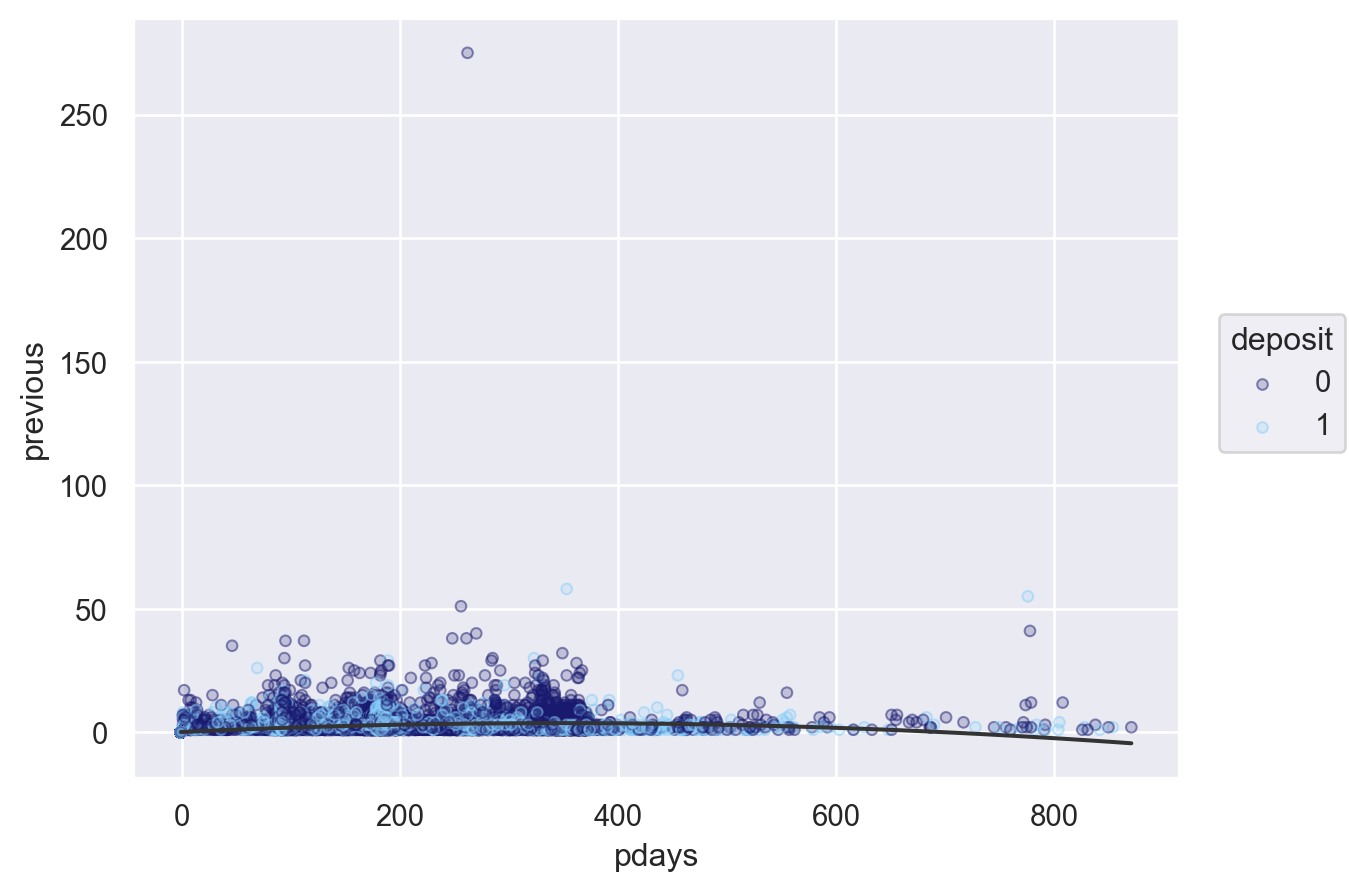

In [82]:
(so
 .Plot((df
        .assign(deposit=np.where(df.deposit==0, "0", "1"))),
       x='pdays',
       y='previous')
 .add(so.Dots(alpha=0.5),
      color='deposit')
 .add(so.Line(color='.2'),
      so.PolyFit(),
      color=None)
 .scale(y=so.Continuous().tick(between=(0, 100)))
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0], color_palette[3]]),})
)

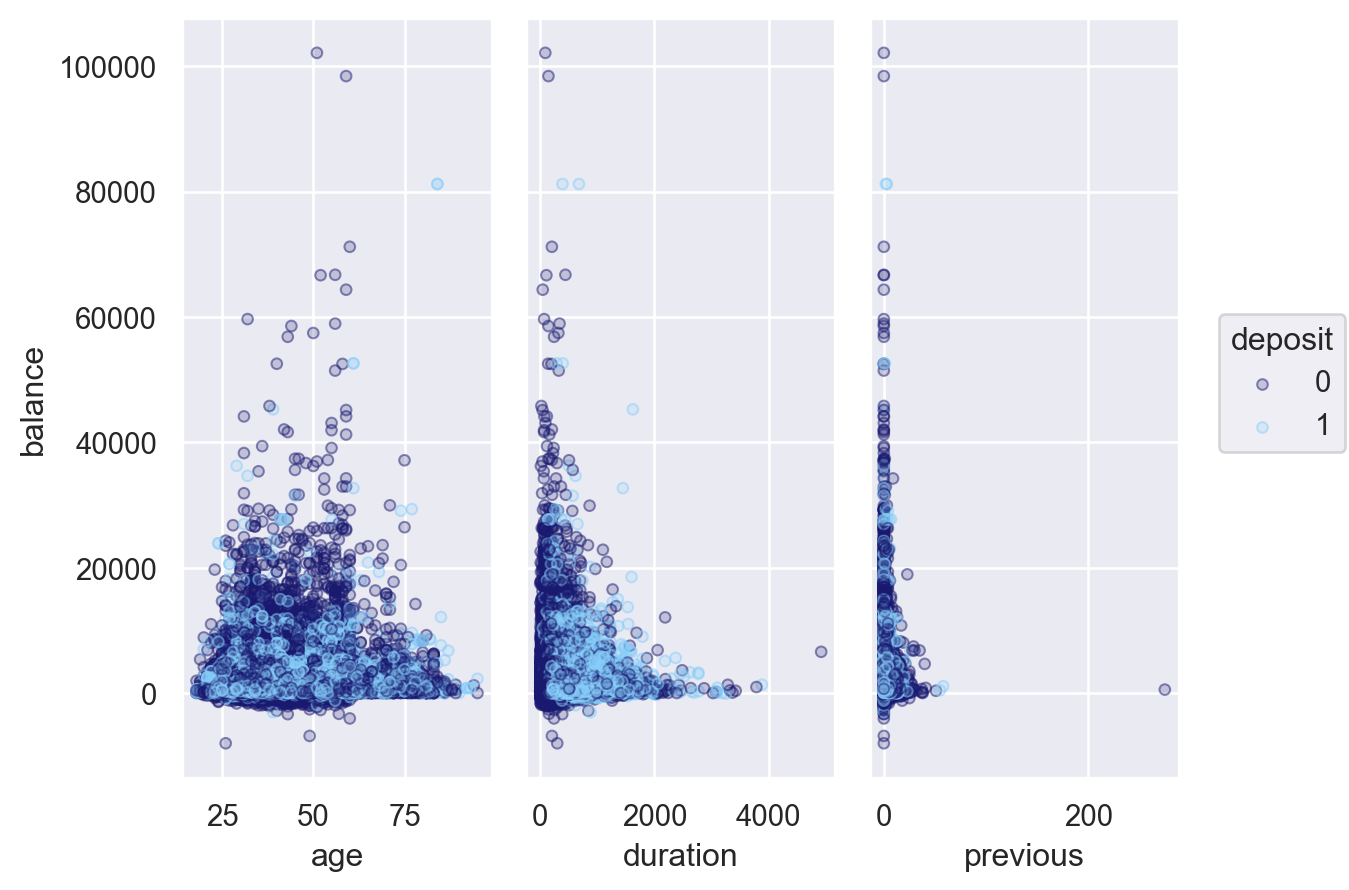

In [83]:
(so
 .Plot((df
        .assign(deposit=np.where(df.deposit==0, "0", "1"))),
       y='balance',
       color='deposit')
 .pair(x=['age', 'duration', 'previous'])
 .add(so.Dots(alpha=0.5))
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0], color_palette[3]]),})
)

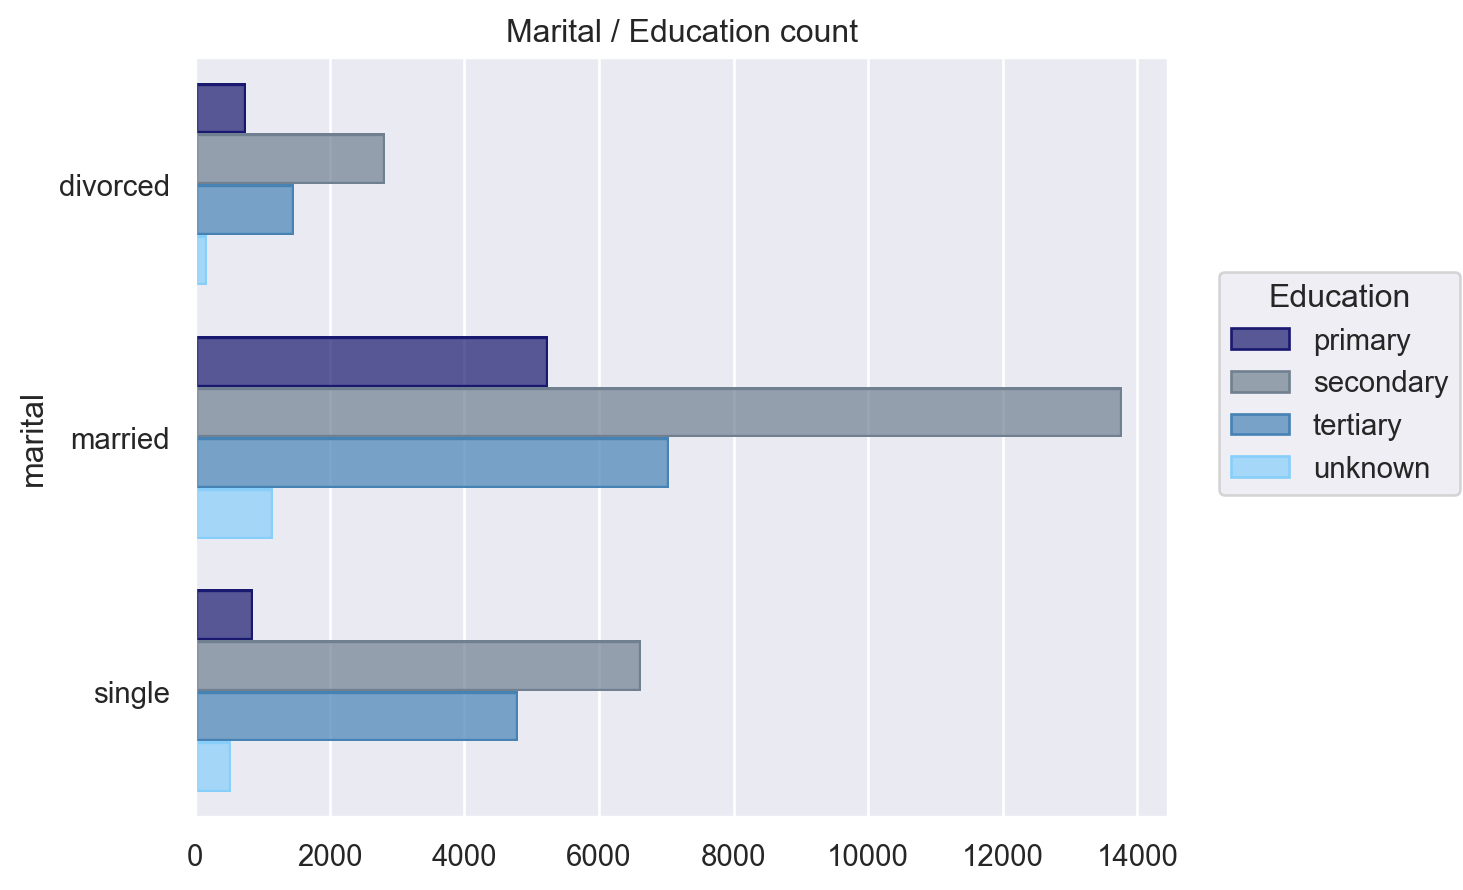

In [84]:
(so
 .Plot((df
 .groupby(['marital', 'education'])
 ['education']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='marital', var_name='education', value_name='count')
),
       x='count',
       y='marital',
       color='education')
 .add(so.Bar(),
      so.Agg(),
      so.Dodge())
 .label(x='',
       y='marital',
       color=str.capitalize,
       title=f'Marital / Education count')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette),})
)

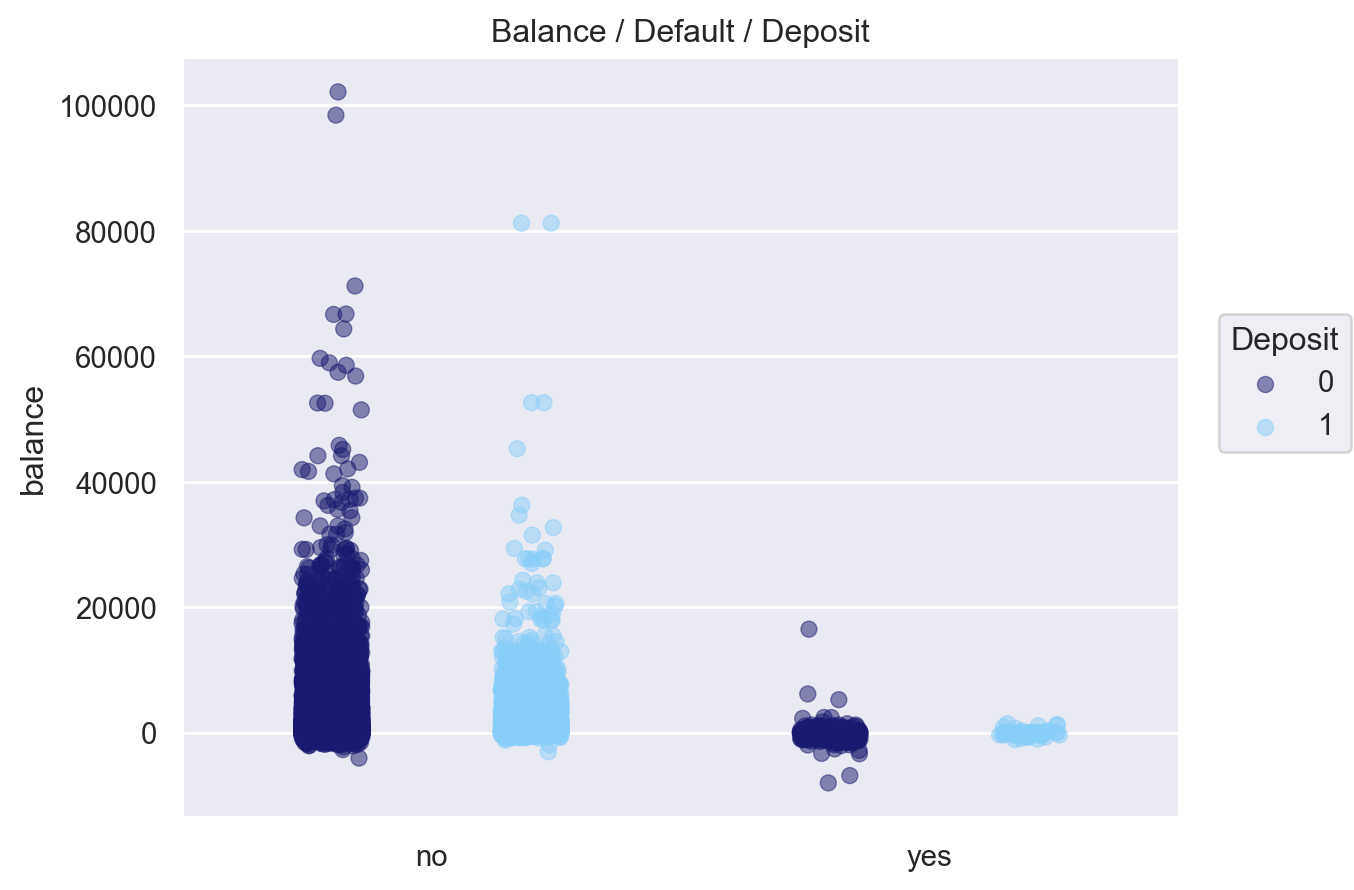

In [85]:
(so
 .Plot((df
        .assign(deposit=np.where(df.deposit==0, "0", "1"))), 
       x='default',
       y='balance',
       color='deposit')
 .add(so.Dot(alpha=0.5),
      so.Dodge(),
      so.Jitter(.3))
 .label(x='',
       y='balance',
       color=str.capitalize,
       title=f'Balance / Default / Deposit')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0], color_palette[3]]),})
)

In [86]:
df_cat = pd.concat([df.select_dtypes('object'), df['deposit']], axis=1)

label = LabelEncoder()
df_encoded = pd.DataFrame()

for i in df_cat.columns:
    if i != "deposit":
        df_encoded[i] = label.fit_transform(df_cat[i])
    else:
        df_encoded[i] = label.fit_transform(df_cat[i].values.ravel())
    
def Cramers_V(var1, var2):
    crosstab = np.array(pd.crosstab(index=var1, columns=var2)) # Cross Tab
    return (association(crosstab, method='cramer'))            # Return Cramer's V

# Create the dataFrame matrix with the returned Cramer's V
rows = []

for var1 in df_encoded:
    col = []

    for var2 in df_encoded:
        V = Cramers_V(df_encoded[var1], df_encoded[var2]) # Return Cramer's V
        col.append(V)                                             # Store values to subsequent columns  
        
    rows.append(col)                                              # Store values to subsequent rows
    
CramersV_results = np.array(rows)
CramersV_df = (pd
               .DataFrame(CramersV_results, columns = df_encoded.columns, index = df_encoded.columns)
               .style
               .background_gradient(cmap="viridis", axis=None)
               .set_sticky(axis="index")
               .set_sticky(axis="columns"))
CramersV_df

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
job,1.000000,0.206012,0.458259,0.036533,0.281740,0.106502,0.150465,0.110240,0.064214,0.135990
marital,0.206012,1.000000,0.121622,0.019230,0.020685,0.051937,0.045091,0.072317,0.029083,0.065926
education,0.458259,0.121622,1.000000,0.015896,0.119339,0.080279,0.122795,0.110105,0.035652,0.072695
default,0.036533,0.019230,0.015896,1.000000,0.006025,0.077234,0.024406,0.058675,0.040403,0.022419
housing,0.281740,0.020685,0.119339,0.006025,1.000000,0.041323,0.213585,0.504213,0.143147,0.139173
loan,0.106502,0.051937,0.080279,0.077234,0.041323,1.000000,0.016274,0.182827,0.055248,0.068185
contact,0.150465,0.045091,0.122795,0.024406,0.213585,0.016274,1.000000,0.512127,0.207471,0.151355
month,0.110240,0.072317,0.110105,0.058675,0.504213,0.182827,0.512127,1.000000,0.214336,0.260237
poutcome,0.064214,0.029083,0.035652,0.040403,0.143147,0.055248,0.207471,0.214336,1.000000,0.311663
deposit,0.135990,0.065926,0.072695,0.022419,0.139173,0.068185,0.151355,0.260237,0.311663,1.000000


**Insights:**
1. Moderately strong association between:
    - job and education
    - housing and month
    - contact and month
2. Observable association between:
    - housing and job 
    - month and deposit
    - poutcome and deposit

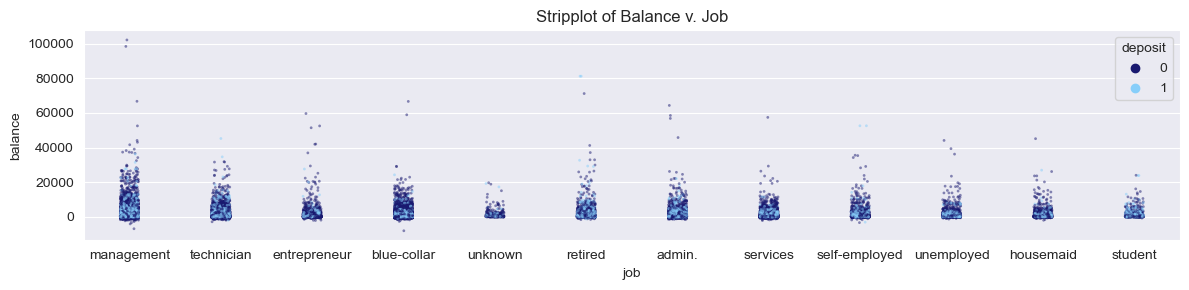

In [87]:
fig, axes = plt.subplots(figsize=(12, 3))
sns.stripplot(data=df, 
              x='job', 
              y=df["balance"], 
              size=2, 
              hue="deposit", 
              palette=[color_palette[0], color_palette[3]], 
              alpha=0.5,
              ax=axes,)
plt.title('Stripplot of Balance v. Job')
plt.tight_layout();

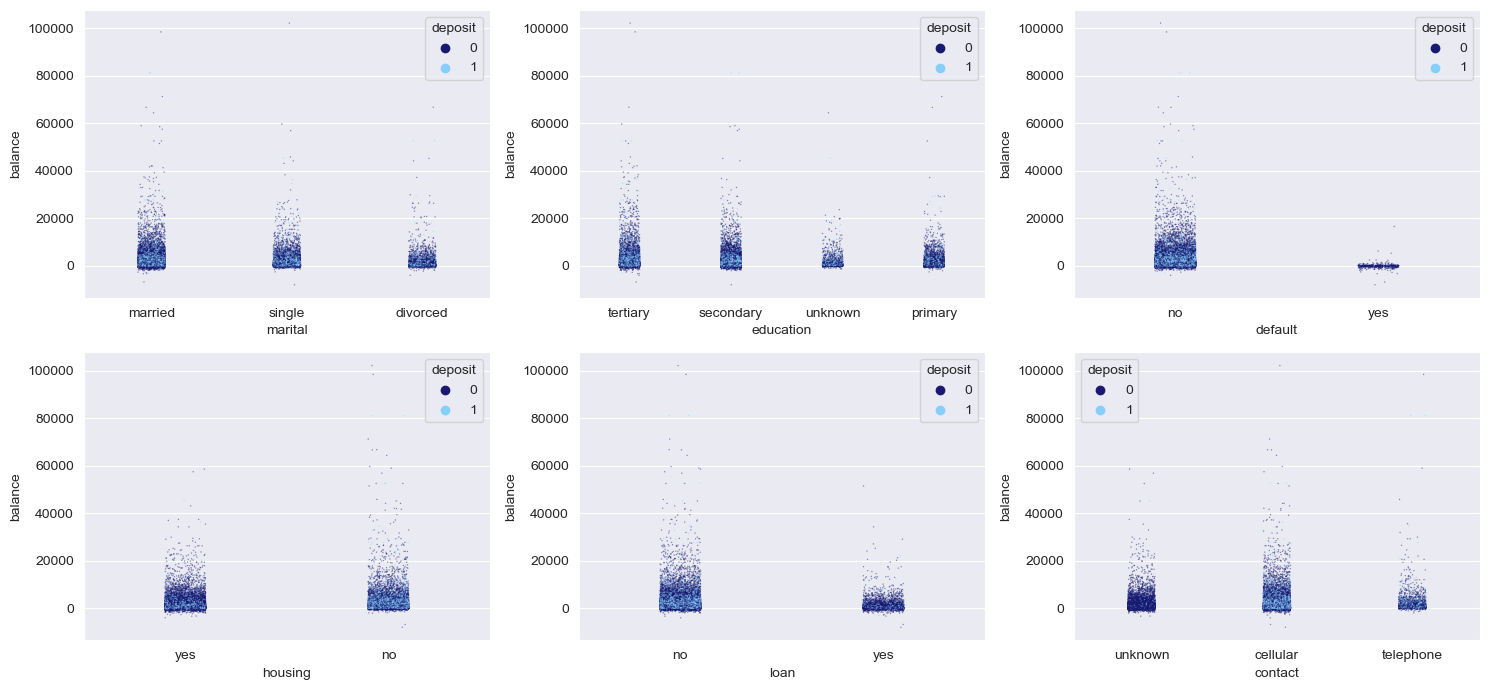

In [88]:
n_cols = 3
n_elements = len(['marital', 'education', 'default', 'housing', 'loan', 'contact'])
n_rows = np.ceil(n_elements / n_cols).astype("int")

y_value = df["balance"]

fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(15, n_rows * 3.5))

for col, ax in zip(['marital', 'education', 'default', 'housing', 'loan', 'contact'], axes.ravel()):
    sns.stripplot(data=df, x=col, y=y_value, ax=ax, size=1, hue="deposit", palette=[color_palette[0], color_palette[3]], alpha=0.5)

plt.tight_layout();